# `HM-OT` on synthetic data: Langevin dynamics on 2d-Waddington volcano

## imports

### mount drive

In [1]:
COLAB = False
if COLAB == True:
    drive.mount('/content/drive')

### pip installs

In [2]:
if COLAB==True:
    !pip install scanpy moscot ott-jax diffrax napari anndata -q
    !pip install "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q
else:
    pass 

### imports

In [3]:
import sys
import pathlib
import os
import random
import importlib

import pandas as pd
from anndata import AnnData
import scanpy as sc

import random
import numpy as np
import torch

from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans

# import plotly.graph_objects as go
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from PIL import Image

import jax
import jax.numpy as jnp
from jax import random as jax_random
import moscot as mt
import moscot.plotting as mpl
from moscot.problems.time import TemporalProblem

### import `HM-OT`

In [4]:
if COLAB == True:
    fh_hmot = "/content/drive/Othercomputers/numac/GitHub/HM-OT" # filehandle for HM-OT
    project_root = pathlib.Path(fh_hmot)
    sys.path.insert(0, fh_hmot)
    sys.path.insert(0, str(project_root / "src"))
else: 
    fh_hmot = '../'
    project_root = pathlib.Path(fh_hmot)
    sys.path.insert(0, fh_hmot)

import src.FRLC as FRLC
import src.FRLC.FRLC_multimarginal as FRLC_multimarginal
import src.HiddenMarkovOT as HiddenMarkovOT

import src.utils.clustering as clustering
import src.utils.util_LR as util_LR
import src.utils.util_zf as util_zf

from src.utils.util_LR import convert_adata
from src.utils.waddington import visual, minima, simulation, differentiation, metrics, landscape_core_volcano, landscape_core_tristable
# TODO: minima is currently the home of function setup_point_clouds_for_waddington_ot
from src.utils.waddington import seed_everything
from src.platting import color_utils, palette_utils, string_utils, spatial_scatter, diffmap, sankey
# import src.plotting as plotting
import experiments.differentiation_map_validation as dmv # for cosine similarity


## settings: `GLOBAL_SEED`, `device`, `dtype`

### set seed

In [5]:
# Set global seed for reproducibility
GLOBAL_SEED = 42
# np.random.seed(GLOBAL_SEED)
seed = seed_everything(GLOBAL_SEED)

🌱 Setting global seed to 42
  ✓ PyTorch seeded
  ✓ JAX PRNG key created
🌱 All available RNGs seeded.


### reload / set `device`, `dtype`

In [6]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(HiddenMarkovOT)
importlib.reload(dmv)

<module 'experiments.differentiation_map_validation' from '/Users/normandie/Documents/GitHub/HM-OT/experiments/../experiments/differentiation_map_validation.py'>

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float32

On device: cpu


## settings: `TIMEPOINTS`, `ASSIGNMENT_RADIUS`, `LANGEVIN` parameters

### landscape, notion of cell type defined through `ASSIGNMENT_RADIUS`

Assignment radius: 1.6
Verification (polar coords):
(-1.564, -2.709)  r= 3.13  θ= 240.0° → A240
( 3.128,  0.000)  r= 3.13  θ=   0.0° → A0
(-1.564,  2.709)  r= 3.13  θ= 120.0° → A120
(-4.799, -2.796)  r= 5.55  θ= 210.2° → B210
(-4.799,  2.796)  r= 5.55  θ= 149.8° → B150
( 4.821, -2.758)  r= 5.55  θ= 330.2° → B330
( 4.821,  2.758)  r= 5.55  θ=  29.8° → B30
(-0.022, -5.555)  r= 5.55  θ= 269.8° → B270
(-0.022,  5.555)  r= 5.55  θ=  90.2° → B90
(-7.705, -4.448)  r= 8.90  θ= 210.0° → C210
( 7.705, -4.448)  r= 8.90  θ= 330.0° → C330
( 7.705,  4.448)  r= 8.90  θ=  30.0° → C30
(-7.705,  4.448)  r= 8.90  θ= 150.0° → C150
(-0.000, -8.897)  r= 8.90  θ= 270.0° → C270
(-0.000,  8.897)  r= 8.90  θ=  90.0° → C90


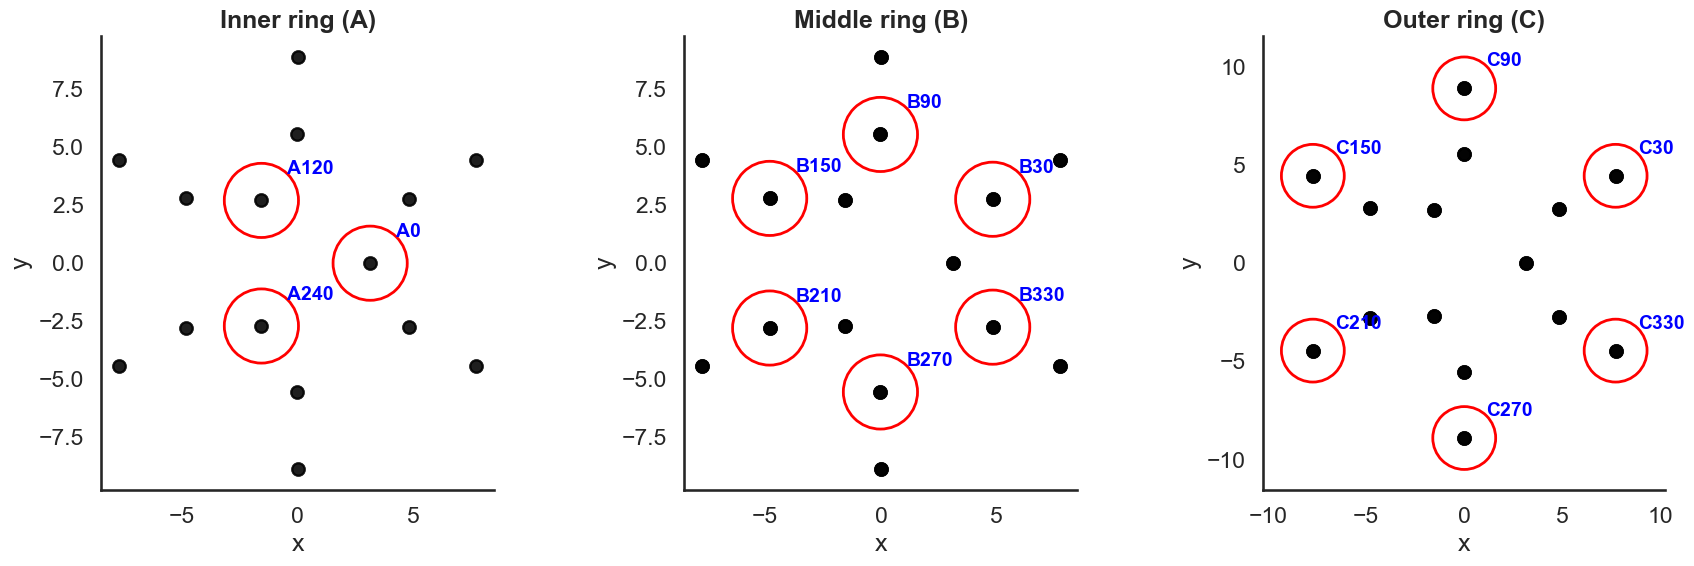


Total clusters: 15


In [8]:
# assignment radius (determines cell type assignments):
ASSIGNMENT_RADIUS = 1.6

MINIMA_POINTS = minima.find_local_minima()
# local minima of the Waddington landscape
# (+ ASSIGNMENT_RADIUS) determine cell type
cluster_dict = visual.create_cluster_dict_and_plot(
    MINIMA_POINTS,
    ASSIGNMENT_RADIUS)

### set `TIMEPOINTS`, `LANGEVIN` parameters

In [9]:
# timepoint indices of snapshots of Langevin dynamics
TIMEPOINTS = [16, 89, 3500] # snapshots taken at these timepoints

# Langevin dynamics parameteters
LANGEVIN_n_particles = 1000 # number of partciles
LANGEVIN_N_timesteps = 4000 # number of time steps
LANGEVIN_dt = 0.2
LANGEVIN_D = 0.014

## run Langevin dynamics, get ground truth global $Q$'s and $T$'s, `Qs_gt_global` and `Ts_gt_global`
Langevin dynamics: trajectory data with no measurement noise

In [10]:
%%time
# snapshots = dynamics snapshots at each timepoint
Xs, Ys, snapshots = simulation.simulate_langevin_with_snapshots(
    n_particles=LANGEVIN_n_particles,
    n_steps=LANGEVIN_N_timesteps,
    dt=LANGEVIN_dt,
    diffusion=LANGEVIN_D,
    snap_times=TIMEPOINTS)

transition_maps, cell_assignments, type_labels = differentiation.build_differentiation_map(
    Xs, Ys, MINIMA_POINTS,
    timepoints=TIMEPOINTS,
    assignment_radius=ASSIGNMENT_RADIUS
)

keys = [f"t{TIMEPOINTS[0]}_to_t{TIMEPOINTS[1]}", f"t{TIMEPOINTS[1]}_to_t{TIMEPOINTS[2]}"]
transition_matrices = [transition_maps[key] for key in keys]
dfs = [pd.DataFrame(mat, index=type_labels, columns=type_labels) for mat in transition_matrices]

# gt cell type assignments
Ss = [
    np.stack((Xs[:, t], Ys[:, t]), axis=1)     # shape (N, 2)
    for t in TIMEPOINTS
]

Qs_gt_global =  minima.build_Qs(Ss, MINIMA_POINTS, ASSIGNMENT_RADIUS)

# compute gt $T$ matrices from full Qs 
Eye = np.eye(LANGEVIN_n_particles) / LANGEVIN_n_particles

T12 = Qs_gt_global[0].T @ Eye @ Qs_gt_global[1]
T23 = Qs_gt_global[1].T @ Eye @ Qs_gt_global[2]
Ts_gt_global = [T12, T23]

CPU times: user 4.55 s, sys: 21.7 ms, total: 4.57 s
Wall time: 4.6 s


### construct canonical labels, colormap

In [11]:
ind_to_str_dict_global = {}
ind_to_str_dict_classic = {}

ind_to_str_dict_classic[0] = 'U'
ind_to_str_dict_classic[1] = 'A240'
ind_to_str_dict_classic[2] = 'A0'
ind_to_str_dict_classic[3] = 'A120'
ind_to_str_dict_classic[4] = 'B210'
ind_to_str_dict_classic[5] = 'B270'
ind_to_str_dict_classic[6] = 'B330'
ind_to_str_dict_classic[7] = 'B30'
ind_to_str_dict_classic[8] = 'B90'
ind_to_str_dict_classic[9] = 'B150'
ind_to_str_dict_classic[10] = 'C210'
ind_to_str_dict_classic[11] = 'C270'
ind_to_str_dict_classic[12] = 'C330'
ind_to_str_dict_classic[13] = 'C30'
ind_to_str_dict_classic[14] = 'C90'
ind_to_str_dict_classic[15] = 'C150' 

ind_to_str_dict_global[0] = 'U'
ind_to_str_dict_global[1] = 'A240'
ind_to_str_dict_global[2] = 'A0'
ind_to_str_dict_global[3] = 'A120'
ind_to_str_dict_global[4] = 'B210'
ind_to_str_dict_global[5] = 'B150'
ind_to_str_dict_global[6] = 'B330'
ind_to_str_dict_global[7] = 'B30'
ind_to_str_dict_global[8] = 'B270'
ind_to_str_dict_global[9] = 'B90'
ind_to_str_dict_global[10] = 'C210'
ind_to_str_dict_global[11] = 'C330'
ind_to_str_dict_global[12] = 'C30'
ind_to_str_dict_global[13] = 'C150'
ind_to_str_dict_global[14] = 'C270'
ind_to_str_dict_global[15] = 'C90'

str_to_ind_dict_global = { v: k for k, v in ind_to_str_dict_global.items() }

In [12]:
_, _, _, ind_to_color_dict_global = palette_utils.get_diffmap_inputs(Qs_gt_global, Ts_gt_global, global_Qs=True)
str_to_color_dict_global = {k : ind_to_color_dict_global[v] for k, v in str_to_ind_dict_global.items()}

In [13]:
str_to_color_dict_global

{'U': (1.0, 1.0, 0.0, 1.0),
 'A240': (0.10980392156862745, 0.9019607843137255, 1.0, 1.0),
 'A0': (1.0, 0.20392156862745098, 1.0, 1.0),
 'A120': (1.0, 0.2901960784313726, 0.27450980392156865, 1.0),
 'B210': (0.0, 0.5372549019607843, 0.2549019607843137, 1.0),
 'B150': (0.0, 0.43529411764705883, 0.6509803921568628, 1.0),
 'B330': (0.6392156862745098, 0.0, 0.34901960784313724, 1.0),
 'B30': (1.0, 0.8588235294117647, 0.8980392156862745, 1.0),
 'B270': (0.47843137254901963, 0.28627450980392155, 0.0, 1.0),
 'B90': (0.0, 0.0, 0.6509803921568628, 1.0),
 'C210': (0.38823529411764707, 1.0, 0.6745098039215687, 1.0),
 'C330': (0.7176470588235294, 0.592156862745098, 0.3843137254901961, 1.0),
 'C30': (0.0, 0.30196078431372547, 0.2627450980392157, 1.0),
 'C150': (0.5607843137254902, 0.6901960784313725, 1.0, 1.0),
 'C270': (0.6, 0.49019607843137253, 0.5294117647058824, 1.0),
 'C90': (0.35294117647058826, 0.0, 0.027450980392156862, 1.0)}

/Users/normandie/Documents/GitHub/HM-OT/experiments/../src/platting/spatial_scatter.py:93: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


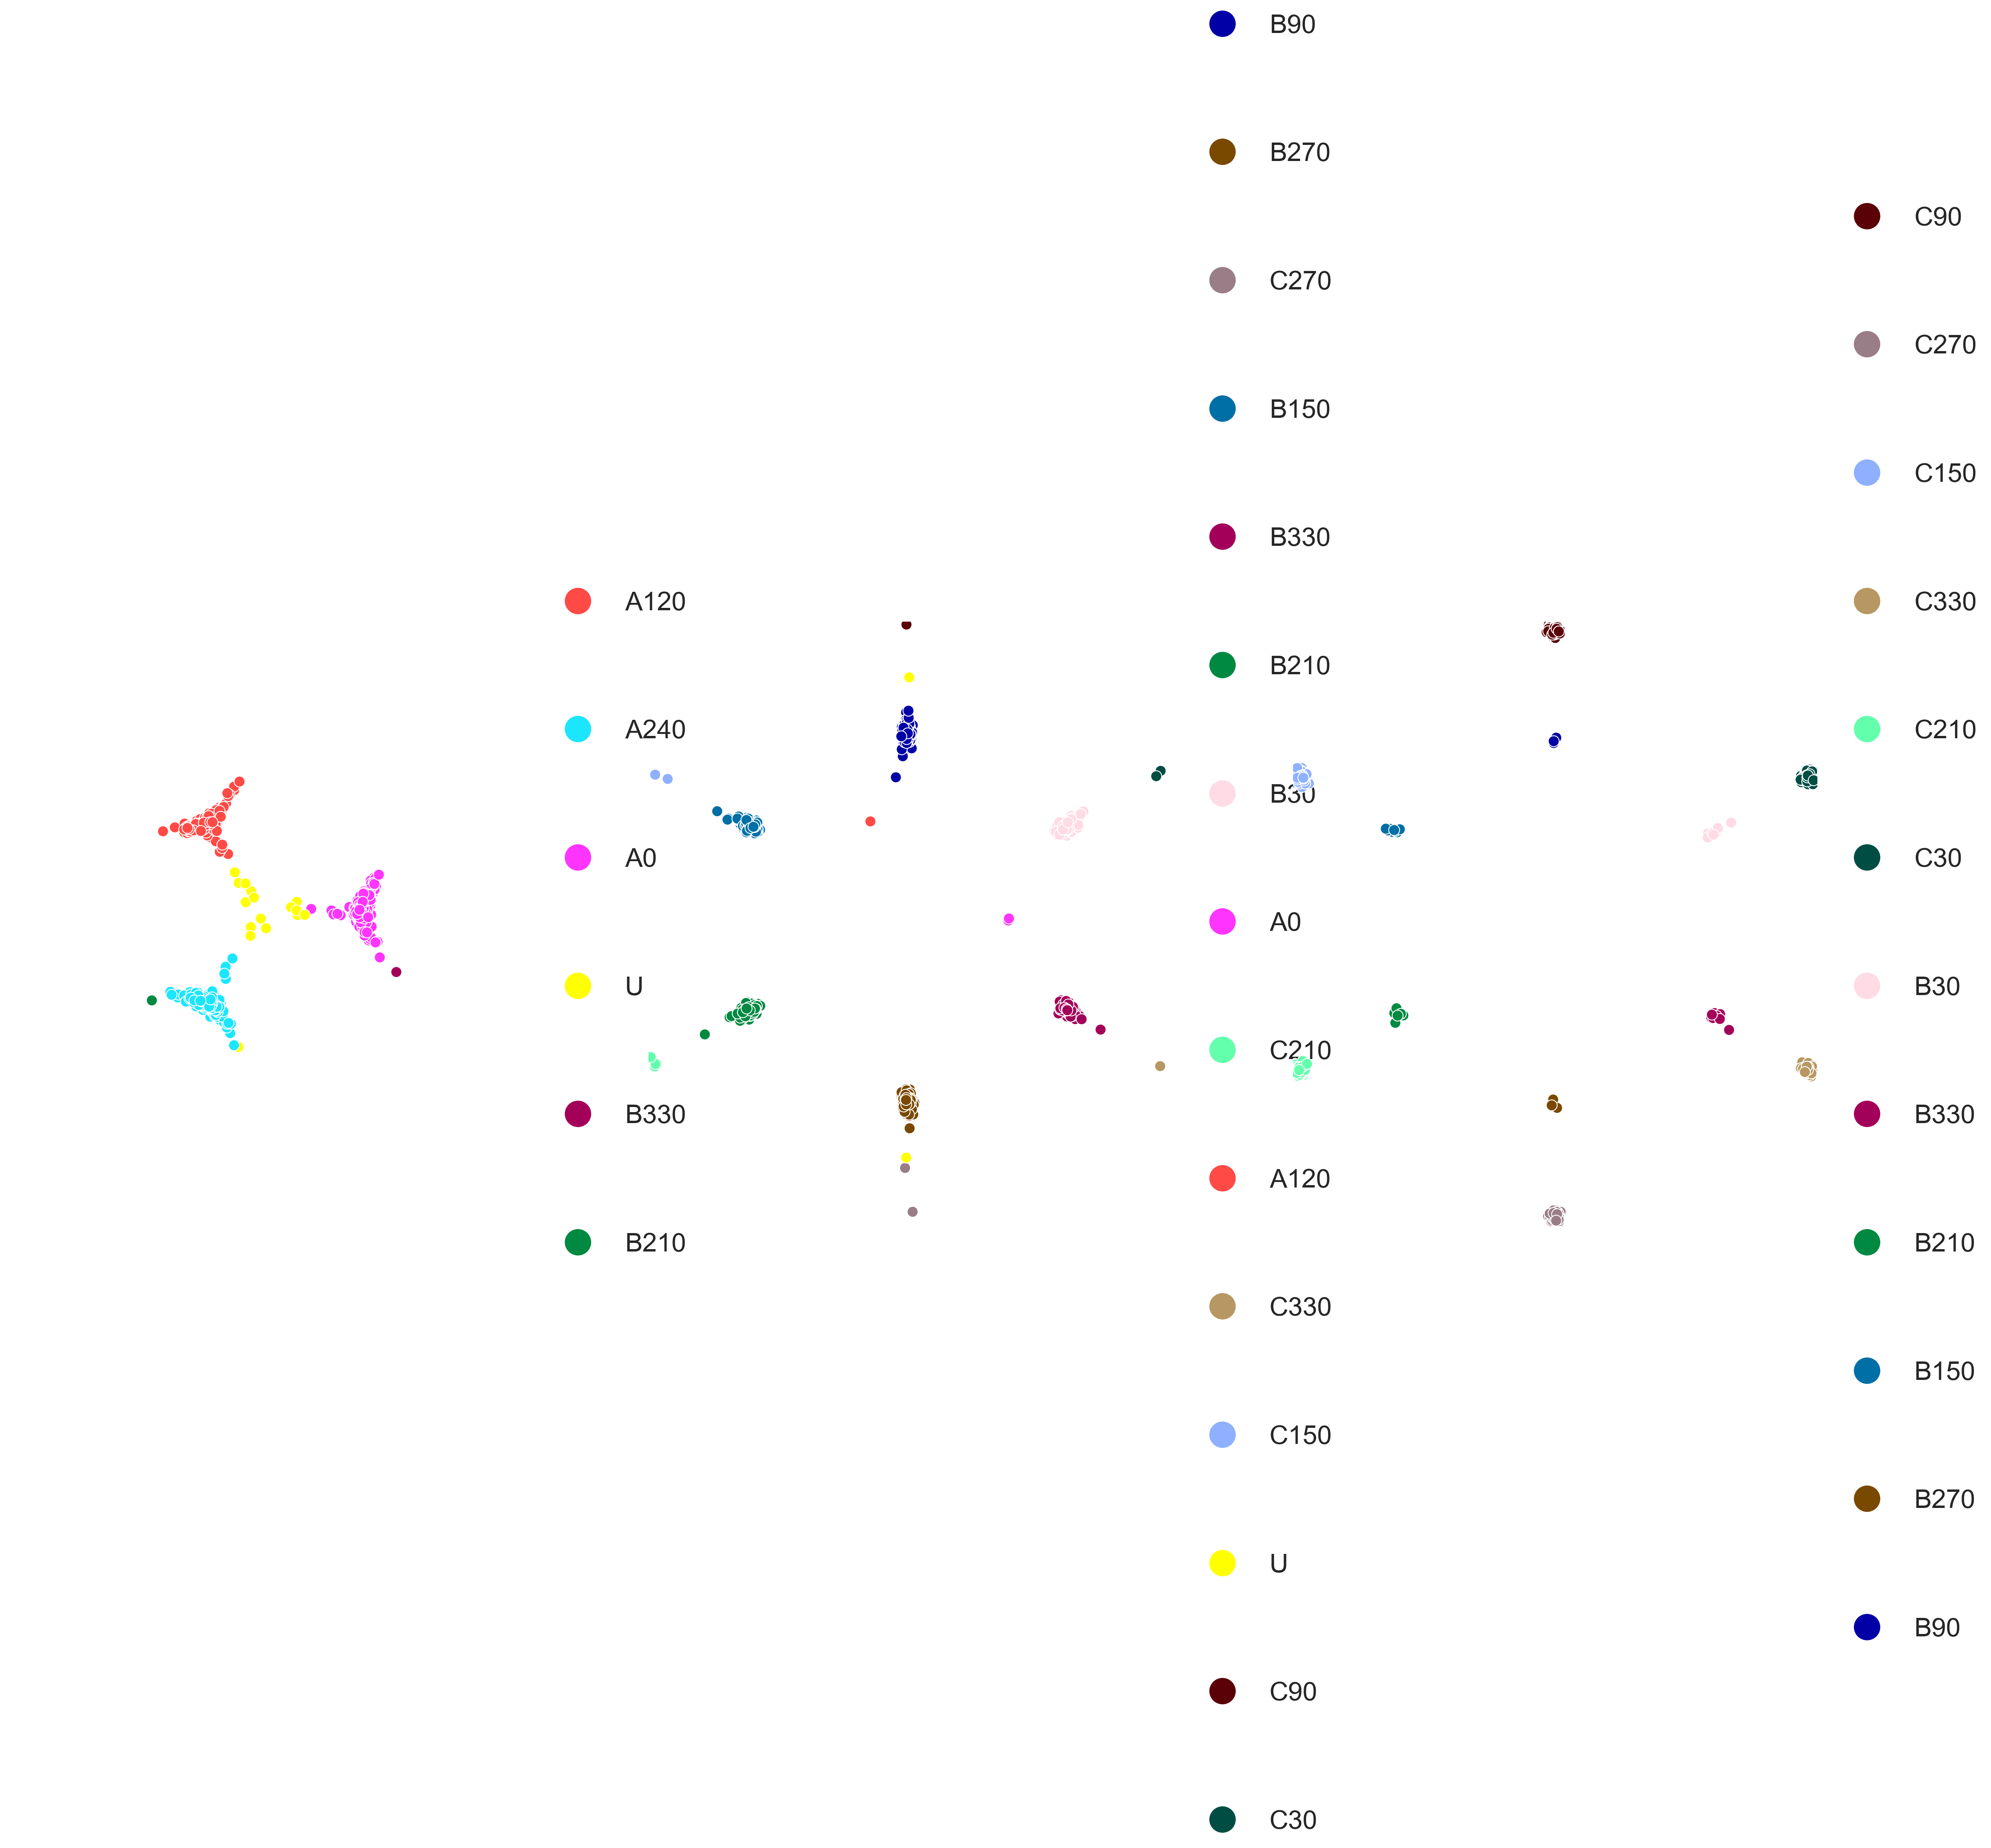

In [14]:
spatial_scatter.plot_clusters_from_QT(
    Qs = Qs_gt_global,
    Ts = Ts_gt_global,
    Ss=Ss,
    ind_to_str_dict=ind_to_str_dict_global,
    str_to_color_dict=str_to_color_dict_global,
    dotsize=400.0,
    key_dotsize=1.0,
    global_Qs=True,
    fontsize=48,)

## dummy plot for labels

/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_9037/3633335767.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


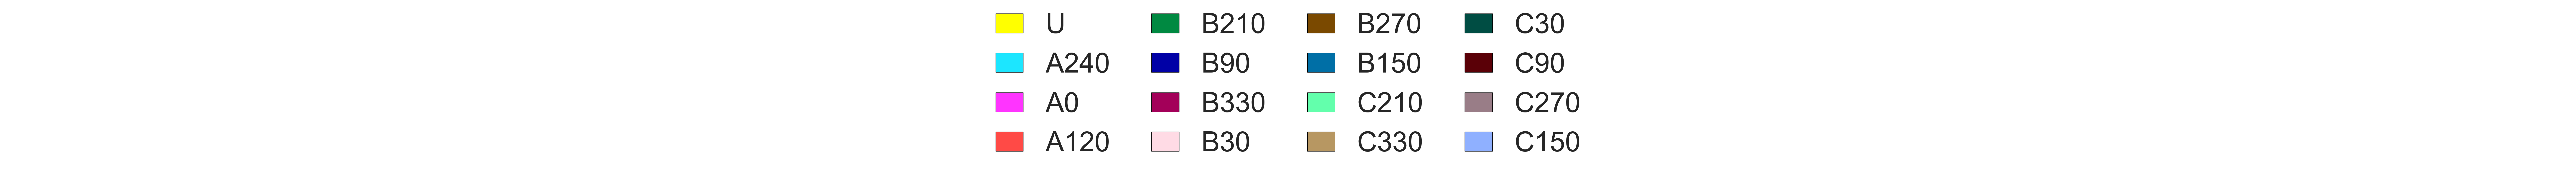

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def draw_color_legend(
    label_list: list[str],
    color_dict: dict[str, tuple],
    *,
    title: str = "Canonical Cell Type Colors",
    ncol: int = 5,
    fontsize: int = 96,
    marker_size: int = 160,
):
    """
    Draws a standalone legend using matplotlib patches (no actual data plotted).
    """
    # Create a list of legend handles
    handles = [
        Patch(facecolor=color_dict[label], edgecolor='black', label=label)
        for label in label_list
    ]

    # Draw only the legend in a figure
    fig, ax = plt.subplots(figsize=(marker_size, 2))
    ax.legend(
        handles=handles,
        loc="center",
        ncol=ncol,
        frameon=False,
        fontsize=fontsize,
        handlelength=1,
        handletextpad=0.8,
        columnspacing=1.5,
    )
    ax.axis("off")
    # plt.title(title, fontsize=fontsize + 2)
    plt.tight_layout()
    plt.show()

canonical_order = ['U', 'A240', 'A0', 'A120', 'B210', 'B90', 'B330', 'B30', 'B270', 'B150',
                   'C210', 'C330', 'C30', 'C90', 'C270', 'C150']

draw_color_legend(canonical_order, str_to_color_dict_global, ncol=4)

## set experiment parameters: `NOISE_min`, `NOISE_max`, `n_noise_levels`, `n_TIMEPOINTS`
range and number of noise levels

noise level 1 / 2: 2.0


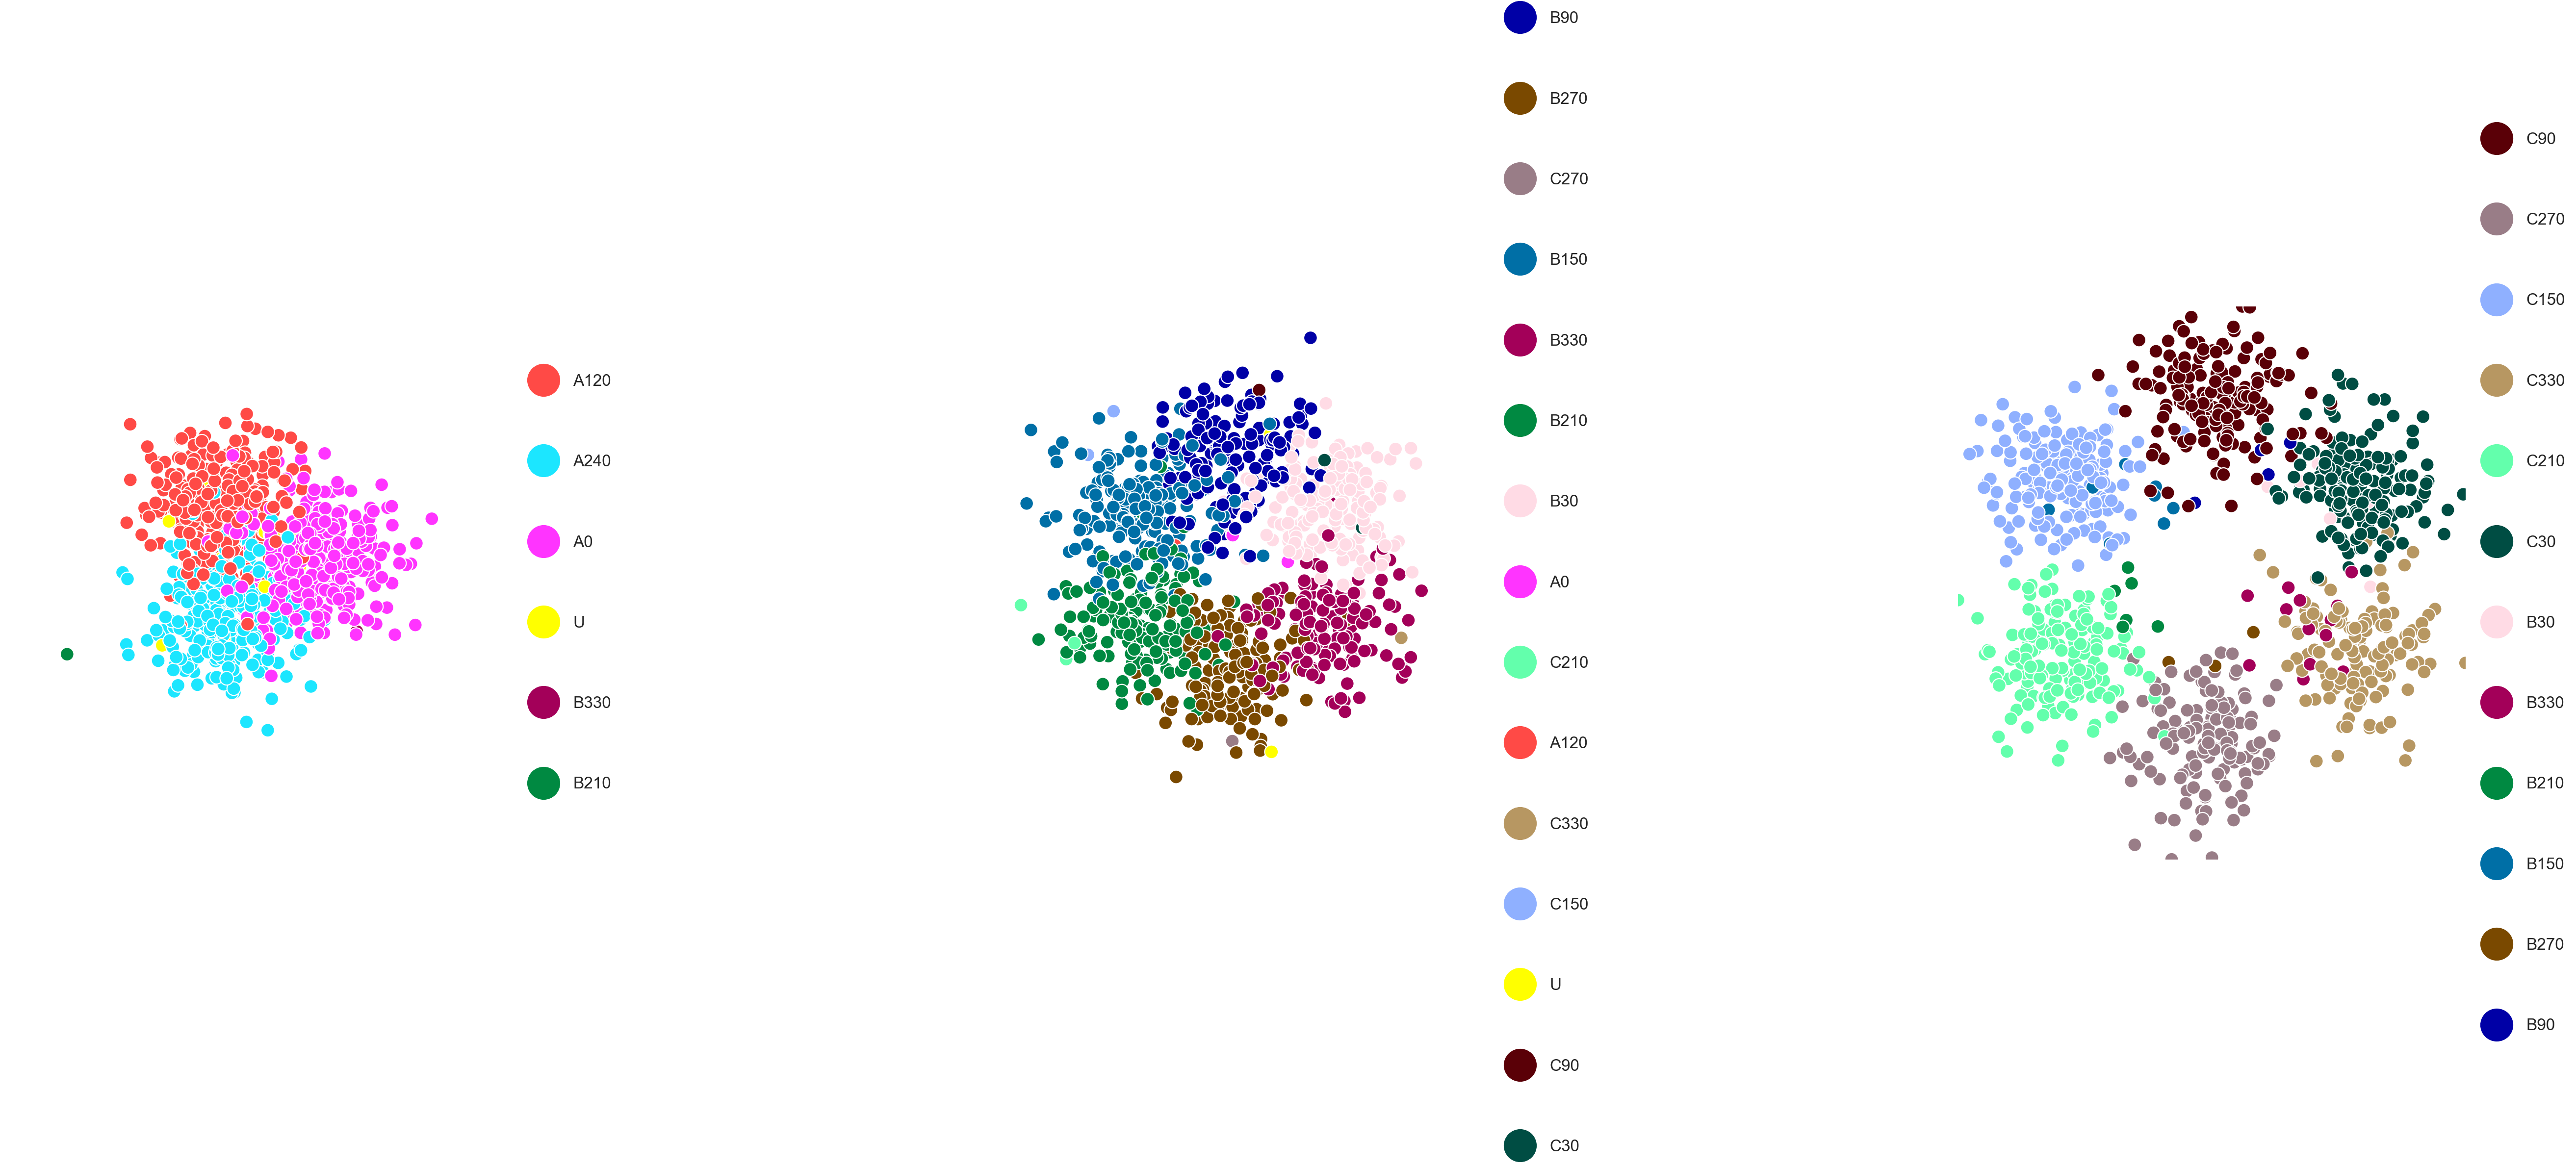

noise level 2 / 2: 4.0


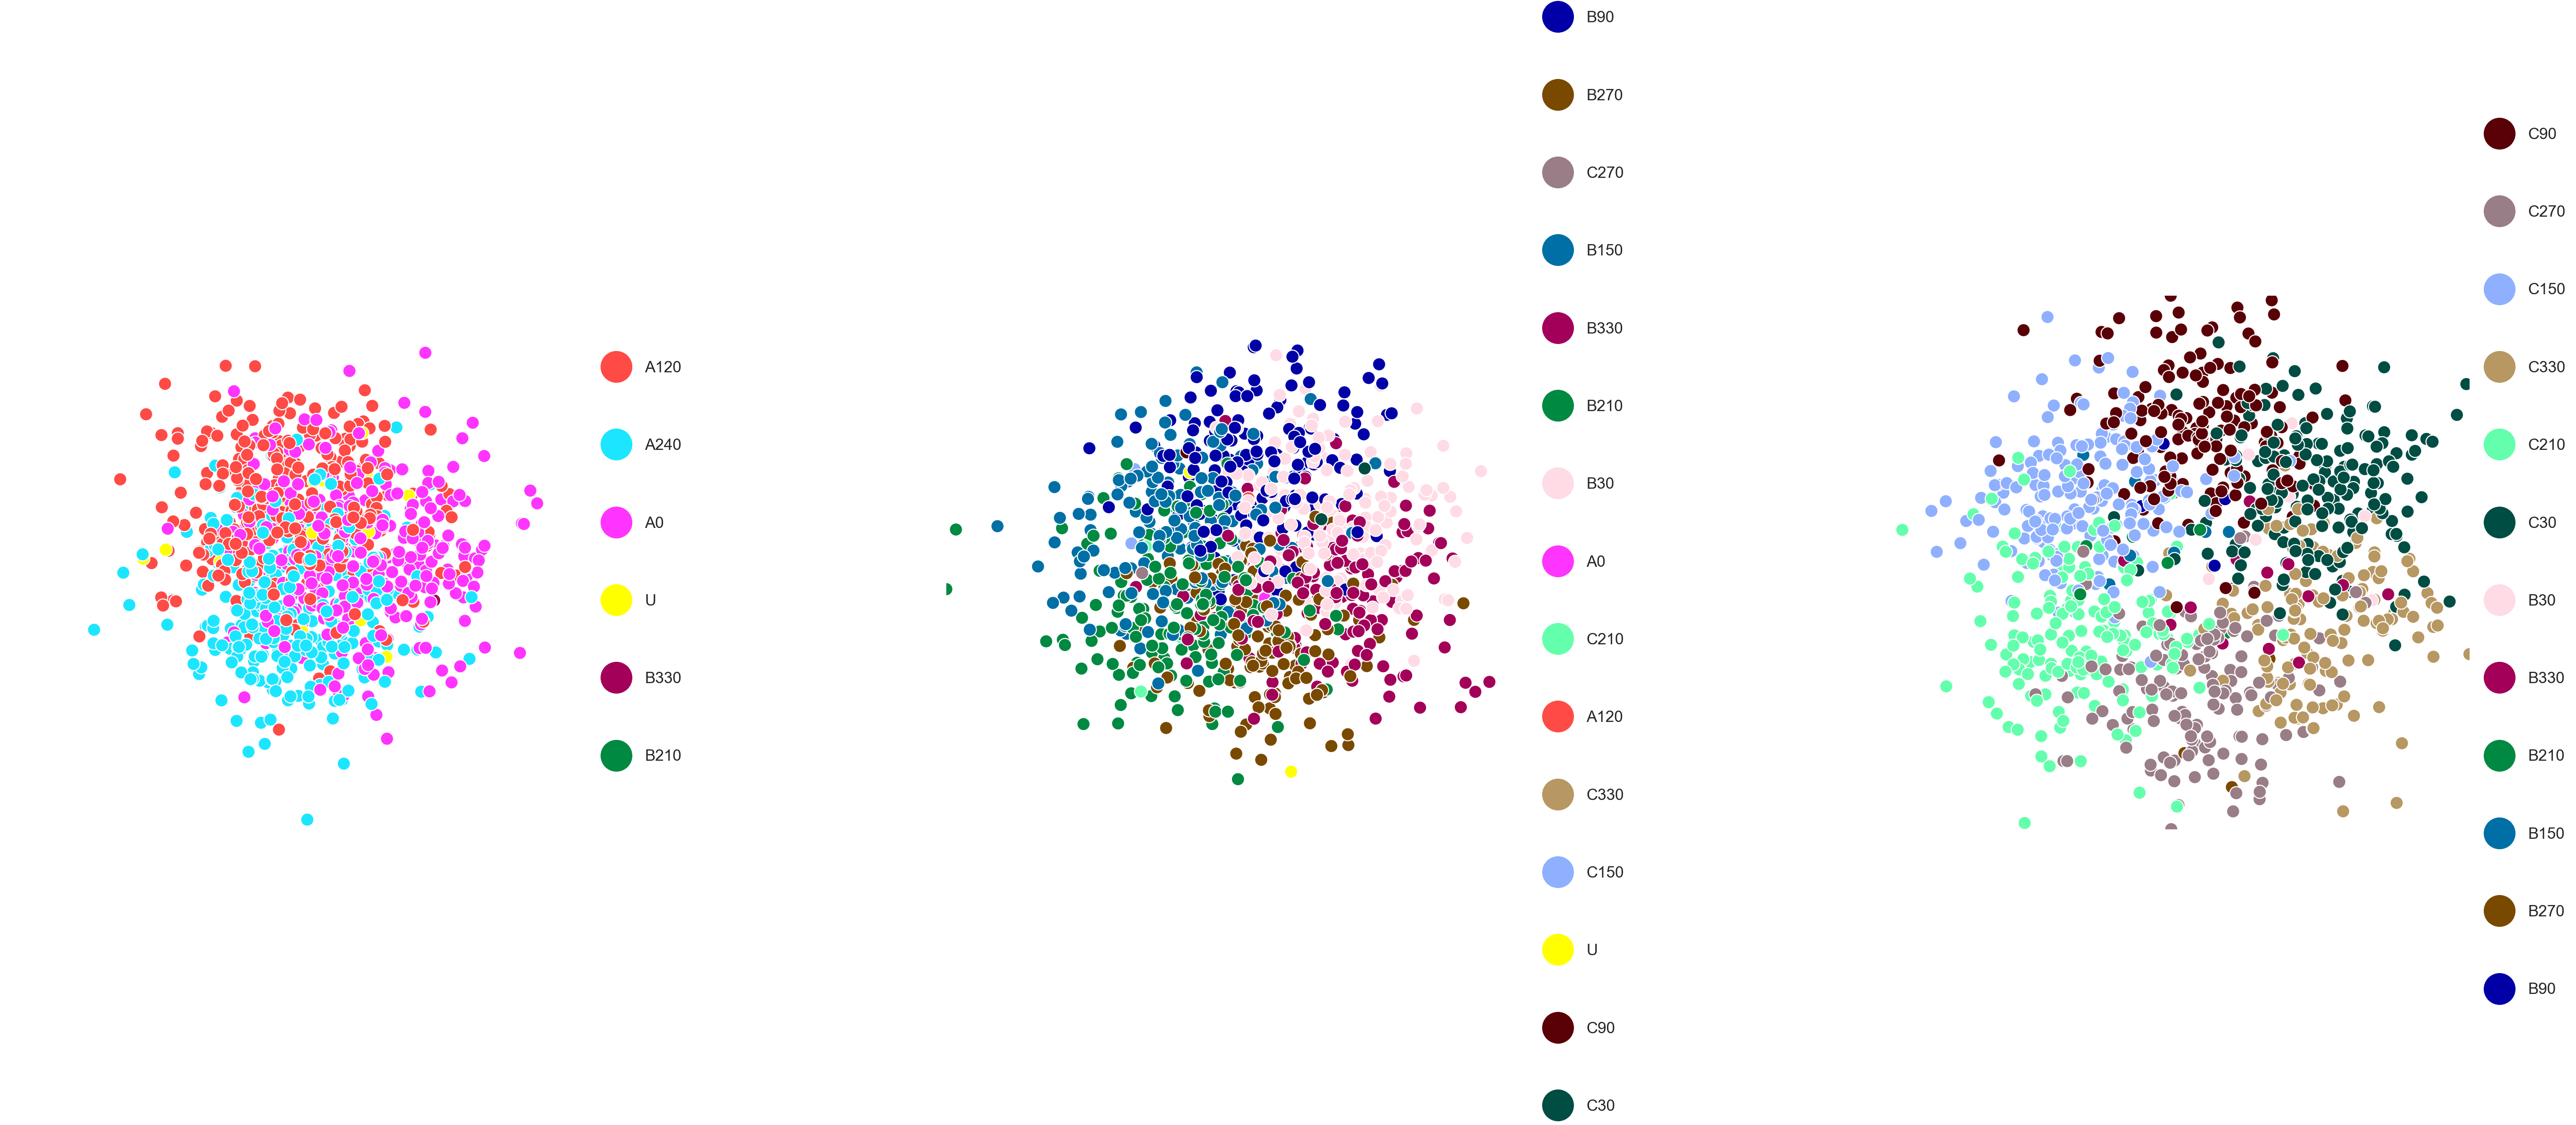

In [16]:
STD=1.0
NOISE_min = 2.0 * STD
NOISE_max = 4.0 * STD
n_TIMEPOINTS = len(TIMEPOINTS)

n_noise_levels = 2
noise_level_range = np.linspace(NOISE_min, NOISE_max, n_noise_levels)


# Shape: (n_noise_levels, n_timepoints, n_particles, 2)
all_matrices = np.random.normal(0, 1, size=(n_noise_levels, n_TIMEPOINTS, LANGEVIN_n_particles, 2))

# Scale by noise levels
matrices = {}
for i, level in enumerate(noise_level_range):
    matrices[level] = [all_matrices[i, t] * level for t in range(n_TIMEPOINTS)]

matrix_list = list(matrices.values()) # list, indexed implicitly by noise level

for i, level in enumerate(noise_level_range):
    print(f'noise level {i+1} / {len(noise_level_range)}: {level}')
    Ss_noisy = [ S + matrices[level][t] for t, S in enumerate(Ss) ]
    spatial_scatter.plot_clusters_from_QT(
        Qs = Qs_gt_global,
        Ts = Ts_gt_global,
        Ss=Ss_noisy,
        ind_to_str_dict=ind_to_str_dict_global,
        str_to_color_dict=str_to_color_dict_global,
        dotsize=400.0,
        key_dotsize=1.0,
        global_Qs=True)

##  set `RANK_LIST`, establish ground truth diffmap

### compute gt labels and proportions with `THRESHOLD`, below which we remove cell types. This determines `RANK_LIST`.

In [17]:
n_timepoints = len(TIMEPOINTS)
THRESHOLD = 20.0 # population threshold, below which we remove cell types
pops = []
for Q in Qs_gt_global:
    ct_pops = Q.sum(axis=0)
    ct_pops = ct_pops[ct_pops > THRESHOLD]  # Filter
    ct_pops = ct_pops / ct_pops.sum()        # Normalize
    pops.append(ct_pops)

# currently not using proportion_tens for supervision,
# this is too unrealistic of an oracle
proportions_tens = [ torch.tensor(local_pops, dtype=dtype).to(device) for local_pops in pops]

labels1_gt_ = np.argmax(Qs_gt_global[0], axis=1)
labels2_gt_ = np.argmax(Qs_gt_global[1], axis=1)
labels3_gt_ = np.argmax(Qs_gt_global[2], axis=1)

labels1_gt = labels1_gt_
labels2_gt = labels2_gt_ + len(set(labels1_gt))
labels3_gt = labels3_gt_ + len(set(labels1_gt)) + len(set(labels2_gt))

gt_clustering_list = [labels1_gt, labels2_gt, labels3_gt]

num_ct = [ len(tens) for tens in proportions_tens ]

RANK_LIST = [(num_ct[0], num_ct[1]), (num_ct[1], num_ct[2])]
print(f"{[pop * 1000 for pop in pops]}")
print(f"RANK_LIST: {RANK_LIST}")

[array([311.54239019, 335.03575077, 353.42185904]), array([165.81892167, 190.23397762, 150.5595117 , 186.16480163,
       142.42115972, 164.80162767]), array([168.05845511, 144.05010438, 184.75991649, 188.93528184,
       146.13778706, 168.05845511])]
RANK_LIST: [(3, 6), (6, 6)]


### plot `Ts_gt_global`

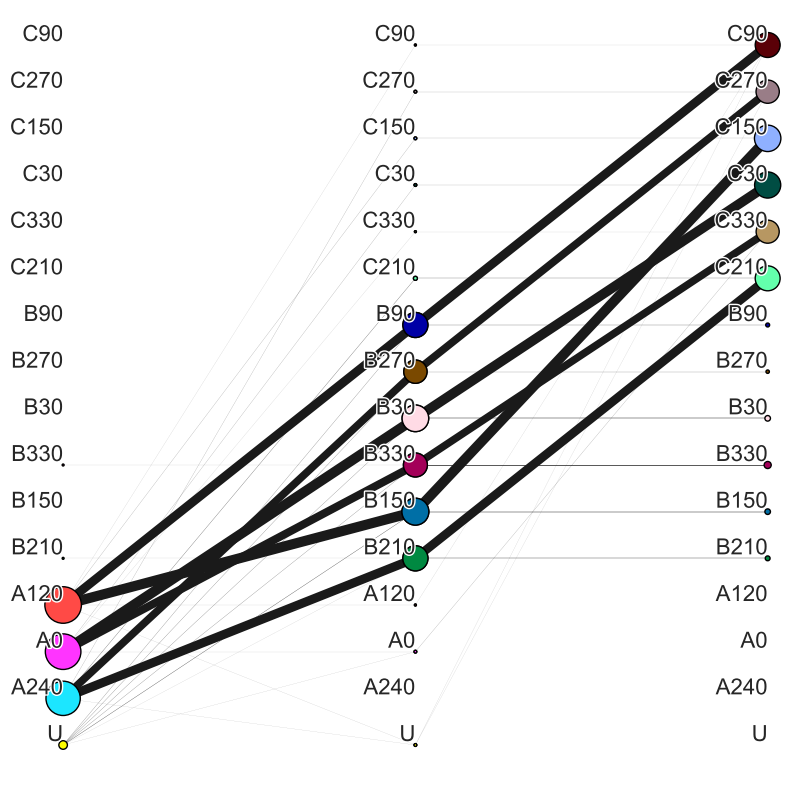

In [18]:
diffmap.diffmap_from_QT(Qs_gt_global, 
                        Ts_gt_global, 
                        global_Qs=True,  
                        ind_to_str_dict=ind_to_str_dict_global, 
                        str_to_color_dict=str_to_color_dict_global,
                        dotsize=2.0,
                        linethick_factor= 40,
                        fontsize=16)

## registering unsupervised clusters to canonical labels through barycenters

### Warm-up registering the non-zero and effective $Q$ submatrices

Towards verifying that our cluster registration works, we will run it on the ground truth assignments of the data sampled without any measurement noise. 

In [19]:
# cluster_dict
def get_nonzero_columns(Q, threshold=1e-10):
    """Get columns with sum > threshold"""
    col_sums = Q.sum(axis=0)
    return Q[:, col_sums > threshold]

Qs_gt_nonzero = [ get_nonzero_columns(Q) for Q in Qs_gt_global]
Qs_gt_effective = [ get_nonzero_columns(Q, threshold=THRESHOLD) for Q in Qs_gt_global]

In [20]:
from scipy.spatial.distance import cdist

# index shift due to "Unclassified" cell type
SHIFT = 1  # 0 → “U”

def get_barycenters(Q, S):
    Q_col_stochastic = Q @ np.diag(1 / Q.sum(axis=0))
    barycenters = Q_col_stochastic.T @ S
    return barycenters

bary_gt_nonzero = [get_barycenters(Q, S) for Q, S in zip(Qs_gt_nonzero, Ss)]
bary_gt_effective = [get_barycenters(Q, S) for Q, S in zip(Qs_gt_effective, Ss)]


def get_valley_indices_and_names(barycenters, cluster_dict, assignment_radius, shift=1):
    # coordinates of valley centers (local minima) in the Waddington landscape
    ordered_valleys = np.array(list(cluster_dict.keys()))
    vi_to_vn = {}  # valley index to valley name mapping
    vi_to_vn[0] = 'U'
    for i, key in enumerate(cluster_dict.keys()):
        vi_to_vn[i + shift] = cluster_dict[key]
    
    to_valley_index = []
    to_valley_name = []
    
    for t in range(len(barycenters)):
        distances = cdist(barycenters[t], ordered_valleys)
        min_distances = np.min(distances, axis=1)  # Get minimum distance for each point
        valley_indices = np.argmin(distances, axis=1) + shift
        
        # Apply assignment radius filter
        # If minimum distance > assignment_radius, set to unclassified (index 0)
        valley_indices = np.where(min_distances <= assignment_radius, valley_indices, 0)
        
        valley_names = [vi_to_vn[vi] for vi in list(valley_indices)]
        to_valley_index.append(valley_indices)
        to_valley_name.append(valley_names)
    
    # index shift due to "Unclassified" cell type
    return to_valley_index, to_valley_name
        

gt_effective_vis, gt_effective_vns = get_valley_indices_and_names(barycenters=bary_gt_effective, 
                                                                  cluster_dict=cluster_dict,
                                                                   assignment_radius=ASSIGNMENT_RADIUS,
                                                                     shift=SHIFT)
print(f'{gt_effective_vis}')
print(f'{gt_effective_vns}')


[array([1, 2, 3]), array([4, 5, 6, 7, 8, 9]), array([10, 11, 12, 13, 14, 15])]
[['A240', 'A0', 'A120'], ['B210', 'B150', 'B330', 'B30', 'B270', 'B90'], ['C210', 'C330', 'C30', 'C150', 'C270', 'C90']]


In [21]:
gt_nonzero_vis, gt_nonzero_vns = get_valley_indices_and_names(barycenters=bary_gt_nonzero, 
                                                              cluster_dict=cluster_dict,
                                                              assignment_radius=ASSIGNMENT_RADIUS, 
                                                              shift=SHIFT)
print(f'{gt_nonzero_vis}')
print(f'{gt_nonzero_vns}')

[array([0, 1, 2, 3, 4, 6]), array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])]
[['U', 'A240', 'A0', 'A120', 'B210', 'B330'], ['U', 'A0', 'A120', 'B210', 'B150', 'B330', 'B30', 'B270', 'B90', 'C210', 'C330', 'C30', 'C150', 'C270', 'C90'], ['B210', 'B150', 'B330', 'B30', 'B270', 'B90', 'C210', 'C330', 'C30', 'C150', 'C270', 'C90']]


## code for assignment problem: cluster registration

In [22]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def solve_assignment_problem(points1, points2):
    """
    Solve the assignment problem between two point clouds.
    
    Parameters:
    points1: numpy array of shape (n, 2) - first point cloud
    points2: numpy array of shape (n, 2) - second point cloud
    
    Returns:
    permutation_matrix: numpy array of shape (n, n) - binary permutation matrix
                       where entry (i,j) = 1 means point i from points1 is assigned to point j from points2
    """
    # Compute pairwise distances between all points
    cost_matrix = cdist(points1, points2, metric='euclidean')
    
    # Solve the assignment problem using Hungarian algorithm
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # Create permutation matrix
    n = len(points1)
    permutation_matrix = np.zeros((n, n), dtype=int)
    permutation_matrix[row_indices, col_indices] = 1
    
    return permutation_matrix


def get_registration(Qs, Ss, cluster_dict):
    """
    registers the barycenters of Qs to the ordered valleys in cluster_dict.
    Returns a list of permutations for each timepoint.
    """
    ordered_valleys = np.array(list(cluster_dict.keys()))
    permutation_list = []

    start = 0
    end = Qs[0].shape[1]

    for t, Q in enumerate(Qs):
        barycenters = get_barycenters(Q, Ss[t]) 
        valleys = ordered_valleys[start:end]
        permutation_matrix = solve_assignment_problem(barycenters, valleys)
        permutation_list.append(permutation_matrix)
        start = end
        end += Qs[t + 1].shape[1] if t + 1 < len(Qs) else 0

    return permutation_list

'''def get_registration(Qs, Ss, str_to_coord_dict, allowed_valley_names_list):
    """
    Registers the barycenters of Qs to the provided canonical valley names at each timepoint.

    Args:
        Qs: List of (N × k_t) soft assignment matrices
        Ss: List of (N × 2) point clouds
        str_to_coord_dict: Dict mapping valley name (e.g., 'B90') → (x, y) coordinates
        allowed_valley_names_list: List of allowed valley name lists per timepoint

    Returns:
        List of permutation matrices (k_t × k_t), one per timepoint.
    """
    permutation_list = []

    for t, (Q, S) in enumerate(zip(Qs, Ss)):
        barycenters = get_barycenters(Q, S)  # shape: (k_t, 2)

        allowed_names = allowed_valley_names_list[t]
        canonical_coords = np.array([str_to_coord_dict[name] for name in allowed_names])  # shape: (k_t, 2)

        perm = solve_assignment_problem(barycenters, canonical_coords)  # shape: (k_t, k_t)
        permutation_list.append(perm)

    return permutation_list''';

## experiment loop

In [23]:
ind_to_str_dict_exp = {}
ind_to_str_dict_exp[0] = 'A240'
ind_to_str_dict_exp[1] = 'A0'
ind_to_str_dict_exp[2] = 'A120'
ind_to_str_dict_exp[3] = 'B210'
ind_to_str_dict_exp[4] = 'B150'
ind_to_str_dict_exp[5] = 'B330'
ind_to_str_dict_exp[6] = 'B30'
ind_to_str_dict_exp[7] = 'B270'
ind_to_str_dict_exp[8] = 'B90'
ind_to_str_dict_exp[9] = 'C210'
ind_to_str_dict_exp[10] = 'C330'
ind_to_str_dict_exp[11] = 'C30'
ind_to_str_dict_exp[12] = 'C150'
ind_to_str_dict_exp[13] = 'C270'
ind_to_str_dict_exp[14] = 'C90'


ind_to_str_dict_cexp = {}

ind_to_str_dict_cexp[0] = 'A240'
ind_to_str_dict_cexp[1] = 'A0'
ind_to_str_dict_cexp[2] = 'A120'
ind_to_str_dict_cexp[3] = 'B210'
ind_to_str_dict_cexp[4] = 'B270'
ind_to_str_dict_cexp[5] = 'B330'
ind_to_str_dict_cexp[6] = 'B30'
ind_to_str_dict_cexp[7] = 'B90'
ind_to_str_dict_cexp[8] = 'B150'
ind_to_str_dict_cexp[9] = 'C210'
ind_to_str_dict_cexp[10] = 'C270'
ind_to_str_dict_cexp[11] = 'C330'
ind_to_str_dict_cexp[12] = 'C30'
ind_to_str_dict_cexp[13] = 'C90'
ind_to_str_dict_cexp[14] = 'C150' 

In [24]:
str_to_valley_dict = { 
    v : k for k, v in cluster_dict.items()
}

str_to_valley_dict

{'A240': (np.float64(-1.5638225833104635), np.float64(-2.708620168317328)),
 'A0': (np.float64(3.12764516662092), np.float64(4.02738880301454e-17)),
 'A120': (np.float64(-1.5638225833104598), np.float64(2.7086201683173305)),
 'B210': (np.float64(-4.79949991301072), np.float64(-2.7961955862206644)),
 'B150': (np.float64(-4.7994999130107185), np.float64(2.7961955862206676)),
 'B330': (np.float64(4.821326937208993), np.float64(-2.758391420565115)),
 'B30': (np.float64(4.821326937208993), np.float64(2.758391420565115)),
 'B270': (np.float64(-0.02182646560408406), np.float64(-5.554588131187466)),
 'B90': (np.float64(-0.02182646560408271), np.float64(5.554588131187467)),
 'C210': (np.float64(-7.704742290784381), np.float64(-4.44833503811304)),
 'C330': (np.float64(7.704742293131411), np.float64(-4.448335034047861)),
 'C30': (np.float64(7.704742293131411), np.float64(4.448335034047861)),
 'C150': (np.float64(-7.704742290784379), np.float64(4.4483350381130435)),
 'C270': (np.float64(-1.5152594

noise level 1 / 2: 2.0
k-means clusters for noise level = 2.0


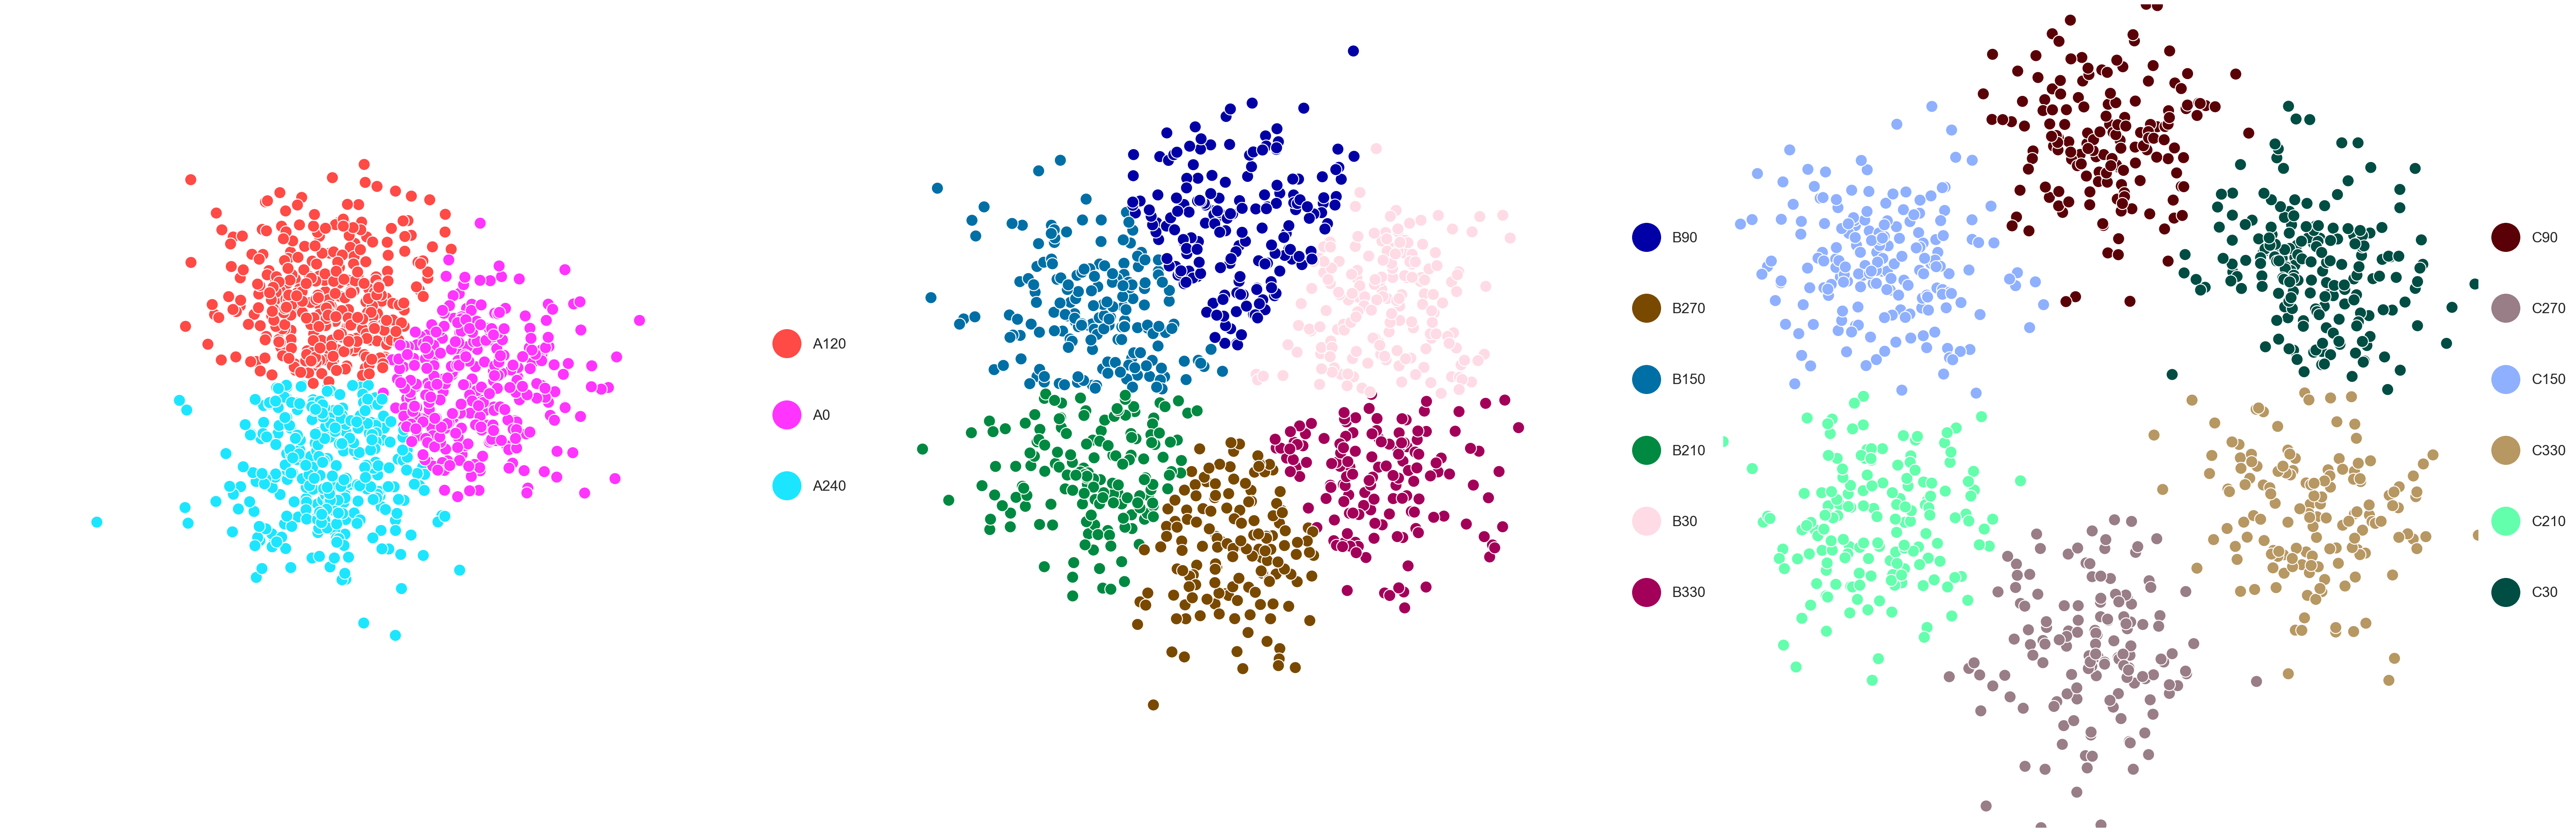

making HM-OT cost matrices for noise level = 2.0
running HM-OT for noise level = 2.0
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Ranks: r1 3, r2 6, r3 6
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
plotting HM-OT clusters for noise level = 2.0


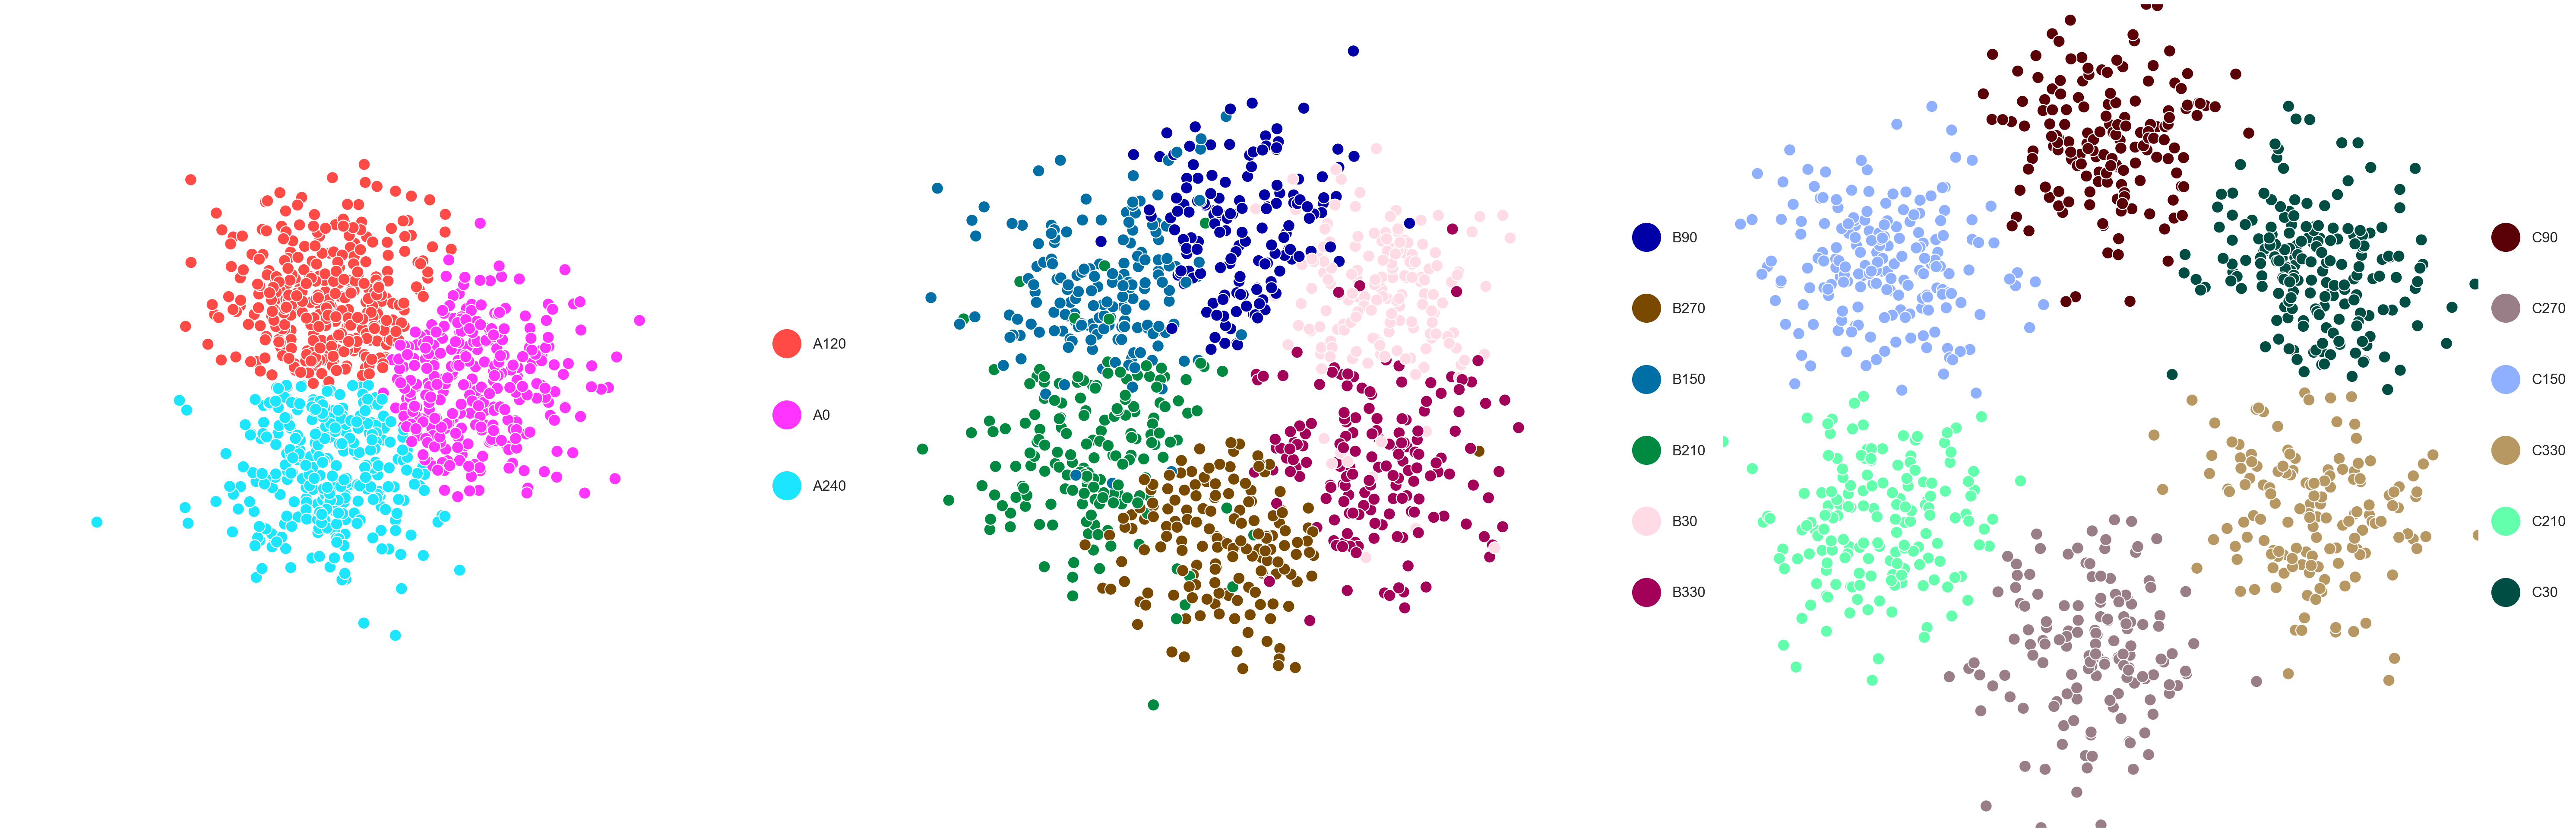

HM-OT Qs for noise level = 2.0 done
plotting HM-OT diffmap for noise level = 2.0


TypeError: diffmap_from_QT() got an unexpected keyword argument 'dotisize'

In [ ]:
%%time

import numpy as np
from scipy.spatial.distance import cdist  
from scipy.optimize import linear_sum_assignment 

ITER = 100
GAMMA = 120.0
ALPHA = 0.0
TAU_IN = 1e5


ALLOWED_VALLEYS_LIST = [
    ['A240', 'A0', 'A120'],  # time-point 1
    ['B210', 'B150', 'B330', 'B90', 'B30', 'B270'],  # time-point 2
    ['C210', 'C330', 'C30', 'C150', 'C270', 'C90'],  # time-point 3
]

# ────────────────────────────────────────────────────────────────────────────────
# initialize lists for storing output
wot_ami_list = []
wot_ari_list = []
hmot_ami_list = []
hmot_ari_list = []

hmot_cos_scores = []
wot_cos_scores = []

hmot_Qs_list = []
km_Qs_list = []

hmot_Ts_list = []
wot_Ts_list = []

SHIFT = 1  # index 0 = "U", valid valleys start at 1

for i, level in enumerate(noise_level_range):
    torch.manual_seed(GLOBAL_SEED)
    print(f'noise level {i+1} / {len(noise_level_range)}: {level}')
    # create noisy snapshots
    Ss_noisy = [ S + matrices[level][t] for t, S in enumerate(Ss) ]
    # run k-means clustering
    kmeans1 = KMeans(n_clusters=RANK_LIST[0][0], random_state=GLOBAL_SEED)
    kmeans2 = KMeans(n_clusters=RANK_LIST[0][1], random_state=GLOBAL_SEED)
    kmeans3 = KMeans(n_clusters=RANK_LIST[1][1], random_state=GLOBAL_SEED)
    # extract k-means labels
    klabels1_ = kmeans1.fit_predict(Ss_noisy[0])
    klabels2_ = kmeans2.fit_predict(Ss_noisy[1])
    klabels3_ = kmeans3.fit_predict(Ss_noisy[2])

    klabels1 = klabels1_
    klabels2 = klabels2_ + len(set(klabels1_))  # shift indices
    klabels3 = klabels3_ + len(set(klabels1_)) + len(set(klabels2_))  # shift indices

    # encode labels as matrices
    Q1_km = np.eye(len(set(klabels1_)))[klabels1_]
    Q2_km = np.eye(len(set(klabels2_)))[klabels2_]
    Q3_km = np.eye(len(set(klabels3_)))[klabels3_]
    Qs_km = [Q1_km, Q2_km, Q3_km]
    
    Perms_km = get_registration(Qs_km, Ss, cluster_dict)

    Qs_reg_km = [ Q @ Perm for Perm, Q in zip(Perms_km, Qs_km) ]
    # ────────────────────────────────────────────────────────────────────────────────
    # visualize k-means clusters
    print(f"k-means clusters for noise level = {level}")

    spatial_scatter.plot_clusters_from_QT(
        Qs = Qs_reg_km,
        Ts = [None, None],
        Ss=Ss_noisy,
        ind_to_str_dict = ind_to_str_dict_exp,
        str_to_color_dict = str_to_color_dict_global,
        dotsize=400.0,
        key_dotsize=1.0,
        global_Qs=False)

    # ────────────────────────────────────────────────────────────────────────────────
    # compute HM-OT objects
    print(f"making HM-OT cost matrices for noise level = {level}")
    C_factors_sequence = []
    for timepoint in range(2):
        tp1 = Ss_noisy[timepoint]
        tp2 = Ss_noisy[timepoint+1]
        _X1 = torch.from_numpy(tp1).type(torch.DoubleTensor).to(device)
        _X2 = torch.from_numpy(tp2).type(torch.DoubleTensor).to(device)
        C12 = torch.cdist(_X1, _X2).to(device)
        C12 = C12.to(dtype)
        I = torch.eye(C12.shape[1]).to(dtype).to(device)
        C_factors_sequence.append(( C12, I ))
    # ────────────────────────────────────────────────────────────────────────────────
    # set HM-OT parameters
    rank_list = RANK_LIST
    iter = ITER
    gamma = GAMMA
    alpha = ALPHA
    tau_in = TAU_IN
    # ────────────────────────────────────────────────────────────────────────────────
    # run HM-OT
    print(f"running HM-OT for noise level = {level}")
    hmot = HiddenMarkovOT.HM_OT(rank_list = rank_list,
                                max_iter = iter,
                                min_iter = iter,
                                device=device,
                                alpha = alpha,
                                gamma = gamma,
                                dtype = dtype,
                                printCost = False,
                                returnFull = False,
                                initialization = 'Full',
                                tau_in = tau_in, # proportion_tens = proportions_tens,
                                )
    # spurious GW components
    A_factors_sequence = [None] * (n_timepoints)
    hmot.gamma_smoothing(C_factors_sequence,
                        A_factors_sequence,
                        Qs_IC = [torch.tensor(Qs_km[0], dtype=dtype).to(device), None, torch.tensor(Qs_km[2], dtype=dtype).to(device)],
                        Qs_freeze = [True, False, True])
    # ────────────────────────────────────────────────────────────────────────────────
    # extract HM-OT output
    Qs = hmot.Q_gammas
    Ts = hmot.T_gammas
    # detatch
    Qs_hmot = [Q.cpu().detach().numpy() for Q in Qs]
    Ts_hmot = [T.cpu().detach().numpy() for T in Ts]

    Perms_hmot = get_registration(Qs_hmot, Ss, cluster_dict)
    Qs_reg_hmot = [ Q @ Perm for Perm, Q in zip(Perms_hmot, Qs_hmot) ]
    T12_reg_hmot = Perms_hmot[0].T @ Ts_hmot[0] @ Perms_hmot[1]
    T23_reg_hmot = Perms_hmot[1].T @ Ts_hmot[1] @ Perms_hmot[2]
    Ts_reg_hmot = [T12_reg_hmot, T23_reg_hmot]

    # Append results to lists
    hmot_Qs_list.append(Qs_reg_hmot)
    hmot_Ts_list.append(Ts_reg_hmot)

    # ────────────────────────────────────────────────────────────────────────────────
    # plot HM-OT clusters
    print(f"plotting HM-OT clusters for noise level = {level}")
    spatial_scatter.plot_clusters_from_QT(
        Qs = Qs_reg_hmot,
        Ts = Ts_reg_hmot,
        Ss=Ss_noisy,
        ind_to_str_dict = ind_to_str_dict_exp,
        str_to_color_dict = str_to_color_dict_global,
        dotsize=400.0,
        key_dotsize=1.0,
        global_Qs=False)
    print(f"HM-OT Qs for noise level = {level} done")
    # ────────────────────────────────────────────────────────────────────────────────
    # plot HM-OT diffmap

    print(f"plotting HM-OT diffmap for noise level = {level}")
    diffmap.diffmap_from_QT([Q * LANGEVIN_n_particles for Q in Qs_reg_hmot], 
                            Ts_reg_hmot, 
                            global_Qs=False,
                            ind_to_str_dict = ind_to_str_dict_exp,
                            str_to_color_dict = str_to_color_dict_global,
                            linethick_factor=40,
                            dotsize=10.0,
                            stretch=2.0,
                            fontsize=32)
                         

    # ────────────────────────────────────────────────────────────────────────────────
    # setup data for W-OT
    adata_12 = minima.setup_point_clouds_for_waddington_ot(Ss_noisy[0], Ss_noisy[1], ct_labels_1=klabels1, ct_labels_2=klabels2)
    adata_12.obs["celltype"] = adata_12.obs["celltype"].astype("category")
    adata_23 = minima.setup_point_clouds_for_waddington_ot(Ss_noisy[1], Ss_noisy[2], ct_labels_1=klabels2, ct_labels_2=klabels3)
    adata_23.obs["celltype"] = adata_23.obs["celltype"].astype("category")
    tp_12 = mt.problems.time.TemporalProblem(adata_12)
    tp_23 = mt.problems.time.TemporalProblem(adata_23)

    tp_12.prepare(time_key='time_point')
    tp_23.prepare(time_key='time_point')

    solve_kwargs = {
        'epsilon': 1e-4,
        'tau_a': 1.0,
        'tau_b': 1.0,
    }
    
    # ────────────────────────────────────────────────────────────────────────────────
    # running W-OT
    
    print(f"running W-OT for noise level = {level}")
    tp_12.solve(**solve_kwargs)
    pi_12 = tp_12.solutions[(0, 1)].transport_matrix
    tp_23.solve(**solve_kwargs)
    pi_23 = tp_23.solutions[(0, 1)].transport_matrix
    
    # ────────────────────────────────────────────────────────────────────────────────
    # make transitions from W-OT
    print(f"making transitions from (W-OT + k-means) for noise level = {level}")
    tp_12.cell_transition(source = 0,
                      target = 1,
                      source_groups="celltype",
                      target_groups="celltype",
                      forward=True,
                      key_added="cell_transition"
                )

    tm = adata_12.uns['moscot_results']['cell_transition']["cell_transition"]['transition_matrix']

    tm_ordered = tm.loc[np.unique(klabels1), np.unique(klabels2)]
    T12_ = tm_ordered.to_numpy()
    Q1 = Qs_km[0] / Qs_km[0].sum()
    T12 = np.diag(np.sum(Q1, axis=0)) @ T12_

    tp_23.cell_transition(source = 0,
                        target = 1,
                        source_groups="celltype",
                        target_groups="celltype",
                        forward=True,
                        key_added="cell_transition"
                    )

    tm = adata_23.uns['moscot_results']['cell_transition']["cell_transition"]['transition_matrix']

    tm_ordered = tm.loc[np.unique(klabels2), np.unique(klabels3)]
    T23_ = tm_ordered.to_numpy()
    Q2 = Qs_km[1] / Qs_km[1].sum()
    T23 = np.diag(np.sum(Q2, axis=0)) @ T23_

    Ts_wot = [T12, T23]

    T12_reg_wot = Perms_km[0].T @ T12 @ Perms_km[1]
    T23_reg_wot = Perms_km[1].T @ T23 @ Perms_km[2]
    Ts_reg_wot = [T12_reg_wot, T23_reg_wot]

    # append results to lists
    wot_Ts_list.append(Ts_reg_wot)
    km_Qs_list.append(Qs_reg_km)

    print(f"W-OT Qs for noise level = {level} done")
    # ────────────────────────────────────────────────────────────────────────────────
    # plot W-OT diffmap

    print(f"plotting (W-OT + $k$-means) diffmap for noise level = {level}")
    diffmap.diffmap_from_QT(Qs_reg_km, 
                            Ts_reg_wot, 
                            global_Qs=False,
                            ind_to_str_dict=ind_to_str_dict_exp,
                            str_to_color_dict=str_to_color_dict_global,
                            dotsize=10.0,
                            linethick_factor=40,
                            stretch=2.0,
                            fontsize=48)

    # ────────────────────────────────────────────────────────────────────────────────
    # compute ARI, AMI
    hmot_ami, hmot_ari = metrics.compute_clustering_metrics(Qs_gt_effective, Qs_hmot)
    hmot_ami_list.append(hmot_ami)
    hmot_ari_list.append(hmot_ari)

    wot_ami, wot_ari = metrics.compute_clustering_metrics(Qs_gt_effective, Qs_km)
    wot_ami_list.append(wot_ami)
    wot_ari_list.append(wot_ari)
    # ────────────────────────────────────────────────────────────────────────────────


## comparing `HM-OT` and $k$-means AMI / ARI at second timepoint, across range of noise levels

In [26]:
hmot_ami_np = np.array(hmot_ami_list)
hmot_ari_np = np.array(hmot_ari_list)
wot_ami_np = np.array(wot_ami_list)
wot_ari_np = np.array(wot_ari_list)

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

tp = 1
plt.figure(figsize=(12, 8))

plt.plot(noise_level_range,
         hmot_ami_np.T[tp, :],
         'r-',
         linewidth=5,
         label='HMOT clusters',
         marker='o',
         markersize=12,
         alpha=1.0)

plt.plot(noise_level_range,
         wot_ami_np.T[tp, :],
         'k-.',
         linewidth=5,
         label='k-means clusters',
         marker='s',
         markersize=12,
         alpha=1.0)

plt.xlabel(f'Measurement noise standard deviation', fontsize=25)
plt.ylabel('Adjusted Mutual Information (AMI)', fontsize=25)
plt.title(f'AMI across varying measurement noise at $t${tp+1}', fontsize=30, fontweight='bold')

plt.legend(fontsize=20, frameon=True, fancybox=True, shadow=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1200x800 with 0 Axes>

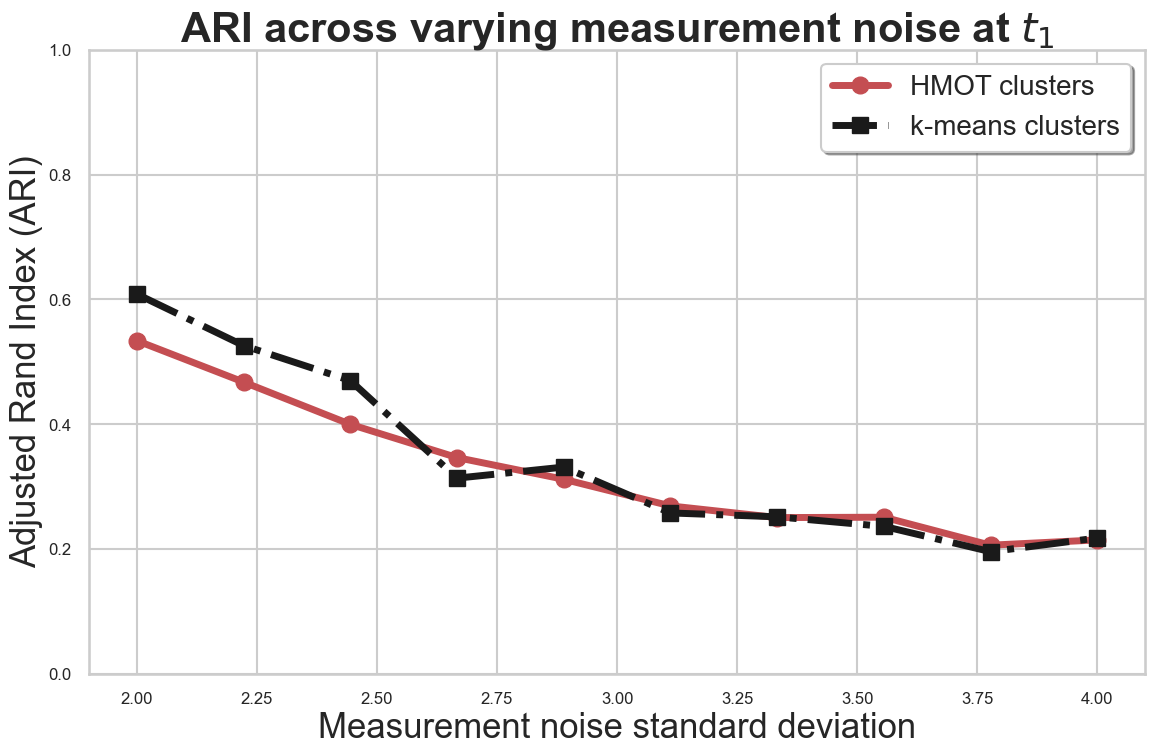

In [ ]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

tp = 1
plt.figure(figsize=(12, 8))

plt.plot(noise_level_range,
         hmot_ari_np.T[tp, :],
         'r-',
         linewidth=5,
         label='HMOT clusters',
         marker='o',
         markersize=12,
         alpha=1.0)

plt.plot(noise_level_range,
         wot_ari_np.T[tp, :],
         'k-.',
         linewidth=5,
         label='k-means clusters',
         marker='s',
         markersize=12,
         alpha=1.0)

plt.xlabel(f'Measurement noise standard deviation', fontsize=25)
plt.ylabel('Adjusted Rand Index (ARI)', fontsize=25)
plt.title(f'ARI across varying measurement noise at $t_1$', fontsize=30, fontweight='bold')

plt.legend(fontsize=20, frameon=True, fancybox=True, shadow=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## NPMI

In [ ]:
def top_N_NPMI_transitions(Qs, Ts, labels_Q, N=10):
    """
    Compute top-N NPMI transitions for each pair of timepoints.

    Args:
        Qs: List of (N × k_t) soft assignment matrices
        Ts: List of (k_t × k_{t+1}) transition matrices
        labels_Q: List of string labels (length = len(Qs)), one list per timepoint
        N: Number of top transitions to keep per timepoint

    Returns:
        top_transitions_list: List of DataFrames (one per T), each with columns:
            ['source', 'target', 'npmi'] (sorted descending)
    """
    top_transitions_list = []

    for i in range(len(Qs) - 1):
        Q1, Q2 = Qs[i], Qs[i + 1]
        T = Ts[i]
        labels1 = labels_Q[i]
        labels2 = labels_Q[i + 1]

        g1 = np.sum(Q1, axis=0)
        g2 = np.sum(Q2, axis=0)
        total_mass1 = g1.sum()
        total_mass2 = g2.sum()

        npmi_scores = []
        for i_row, src_label in enumerate(labels1):
            for j_col, tgt_label in enumerate(labels2):
                p_joint = T[i_row, j_col]
                if p_joint > 0:
                    p_x = g1[i_row] / total_mass1
                    p_y = g2[j_col] / total_mass2
                    npmi = dmv.NPMI(p_joint, p_x, p_y)
                    npmi_scores.append((src_label, tgt_label, npmi))

        # sort and keep top-N
        top = sorted(npmi_scores, key=lambda x: x[2], reverse=True)[:N]
        df = pd.DataFrame(top, columns=["source", "target", "npmi"])
        top_transitions_list.append(df)

    return top_transitions_list

In [ ]:
NPMI_VALLEYS_LIST = [
    ['A240', 'A0', 'A120'],  # time-point 1
    ['B210', 'B90', 'B330', 'B30', 'B270', 'B150'],  # time-point 2
    ['C210', 'C330', 'C30', 'C90', 'C270', 'C150'],  # time-point 3
]

top_transitions = top_N_NPMI_transitions(hmot_Qs_list[0], hmot_Ts_list[0], NPMI_VALLEYS_LIST, N=10)

In [ ]:
top_transitions 

[  source target      npmi
 0   A240   B270  0.625631
 1     A0    B30  0.612033
 2     A0   B330  0.611989
 3   A120    B90  0.602108
 4   A120   B150  0.602070
 5   A240   B210  0.587553
 6   A120   B210 -0.421524
 7     A0   B270 -0.895473,
   source target      npmi
 0   B270   C270  0.994317
 1   B330   C330  0.977228
 2   B150   C150  0.971101
 3    B30    C30  0.951447
 4    B90    C90  0.940234
 5   B210   C210  0.937839
 6   B210    C90 -0.137380
 7   B150    C30 -0.247874
 8   B330    C30 -0.306229
 9   B270   C330 -0.471609]

In [ ]:
def NPMI_t1_to_t3_matrix(Qs, Ts, labels_Q):
    """
    Compute full matrix of NPMI scores between clusters at timepoint 1 and timepoint 3

    Args:
        Qs: List of soft assignment matrices [Q0, Q1, Q2]
        Ts: List of transition matrices [T01, T12]
        labels_Q: List of string label lists for each timepoint [labels0, labels1, labels2]

    Returns:
        DataFrame with columns ['source', 'target', 'npmi'] for all (t1, t3) cluster pairs.
    """
    Q0, Q1, Q2 = Qs
    T01, T12 = Ts
    labels0, labels1, labels2 = labels_Q

    # Compute composite transition T02 = T01 @ T12
    g0 = np.sum(Q0, axis=0)
    g1 = np.sum(Q1, axis=0)
    g2 = np.sum(Q2, axis=0)

    T02 = T01 @ np.diag(1/g1) @ T12

    total_mass0 = g0.sum()
    total_mass2 = g2.sum()

    npmi_scores = []
    for i_row, src_label in enumerate(labels0):
        for j_col, tgt_label in enumerate(labels2):
            p_joint = T02[i_row, j_col]
            if p_joint > 0:
                p_x = g0[i_row] / total_mass0
                p_y = g2[j_col] / total_mass2
                npmi = dmv.NPMI(p_joint, p_x, p_y)
                npmi_scores.append((src_label, tgt_label, npmi))

    df = pd.DataFrame(npmi_scores, columns=["source", "target", "npmi"])
    return df

noise level 2.0


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_29462/3260667041.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


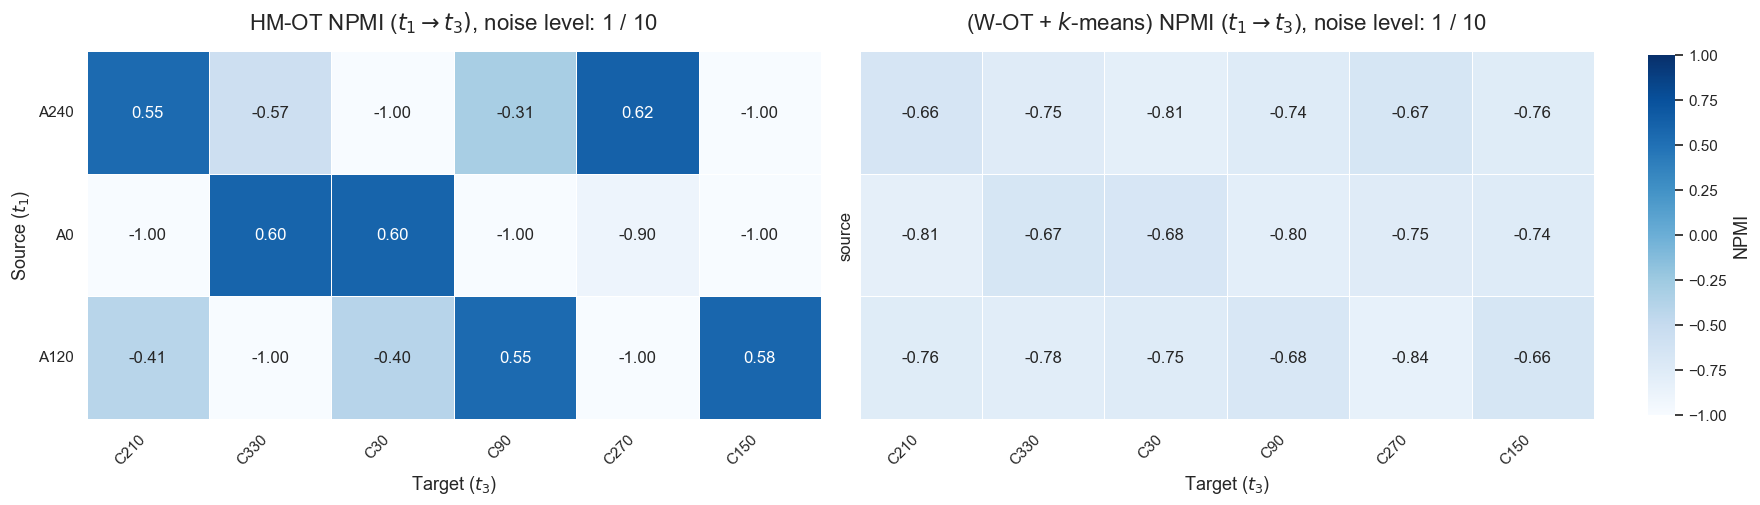

noise level 2.2222222222222223


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_29462/3260667041.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


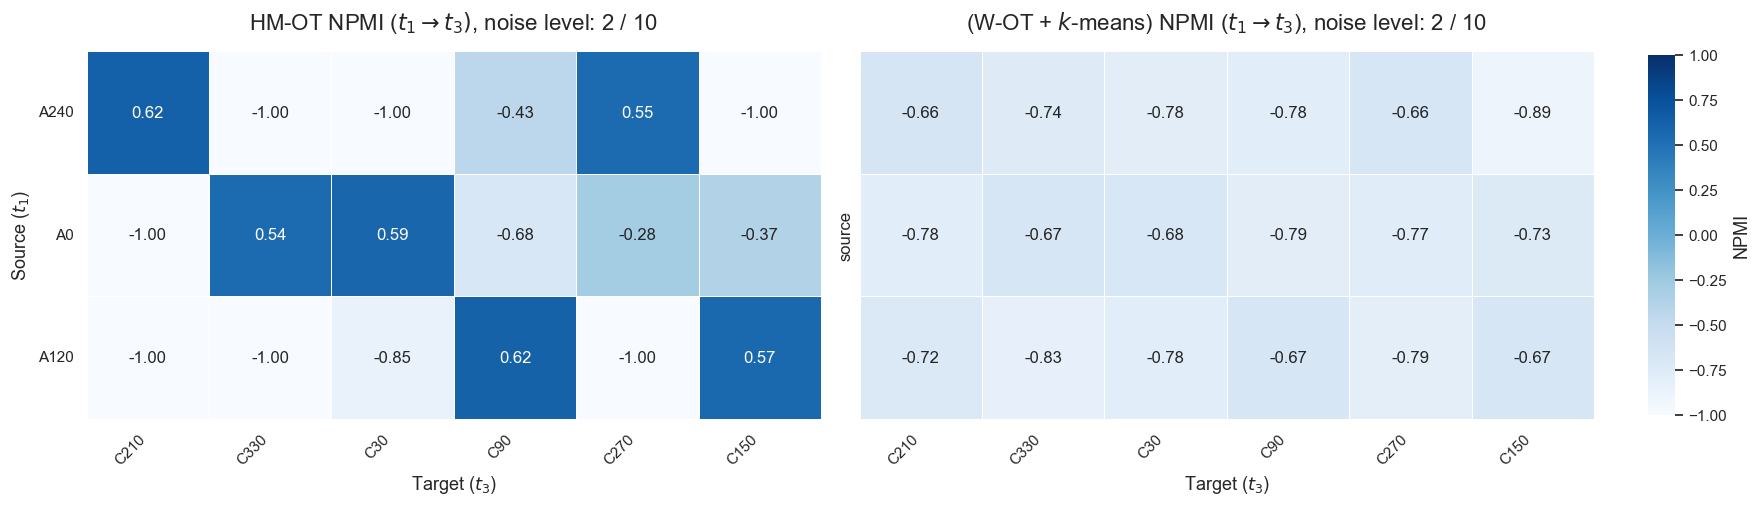

noise level 2.4444444444444446


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_29462/3260667041.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


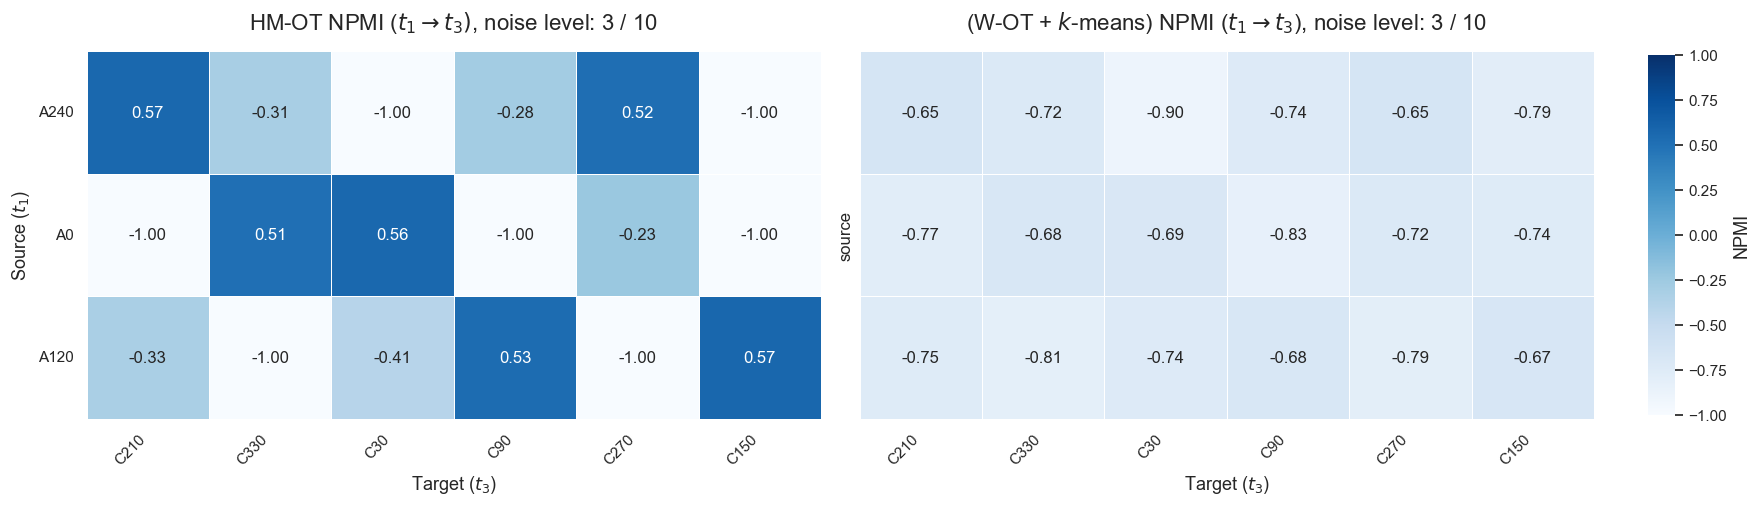

noise level 2.6666666666666665


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_29462/3260667041.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


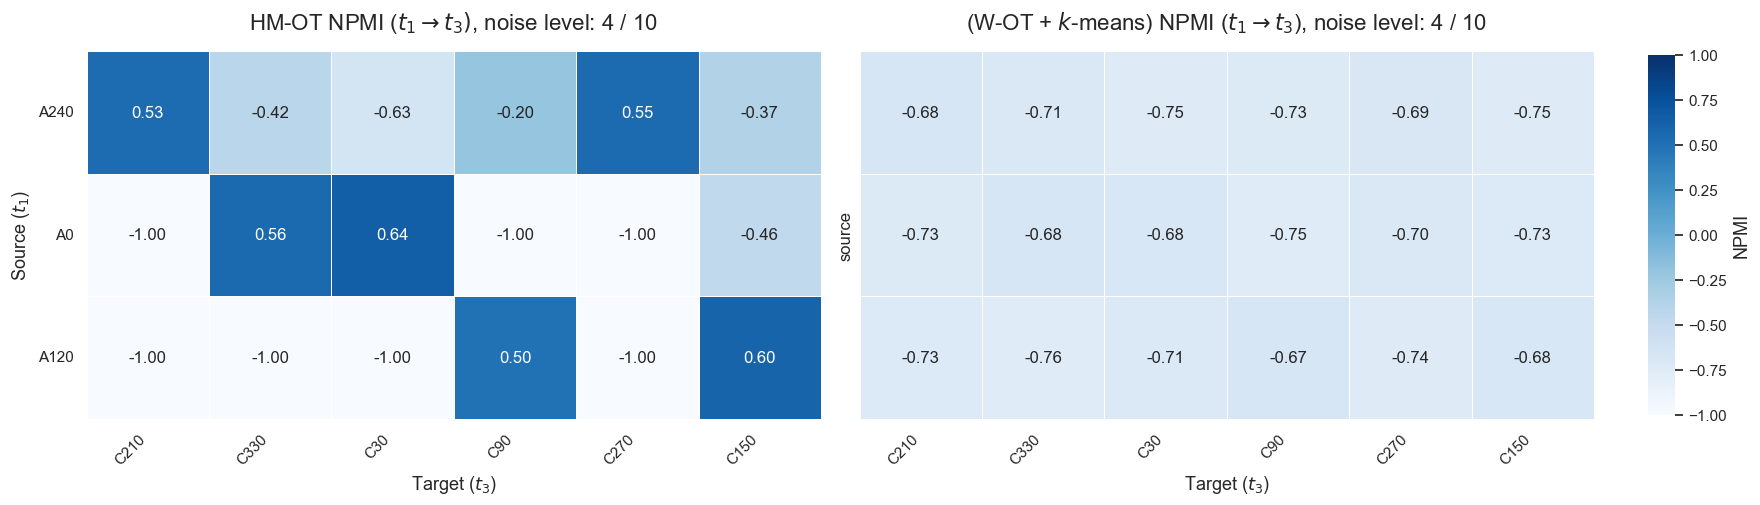

noise level 2.888888888888889


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_29462/3260667041.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


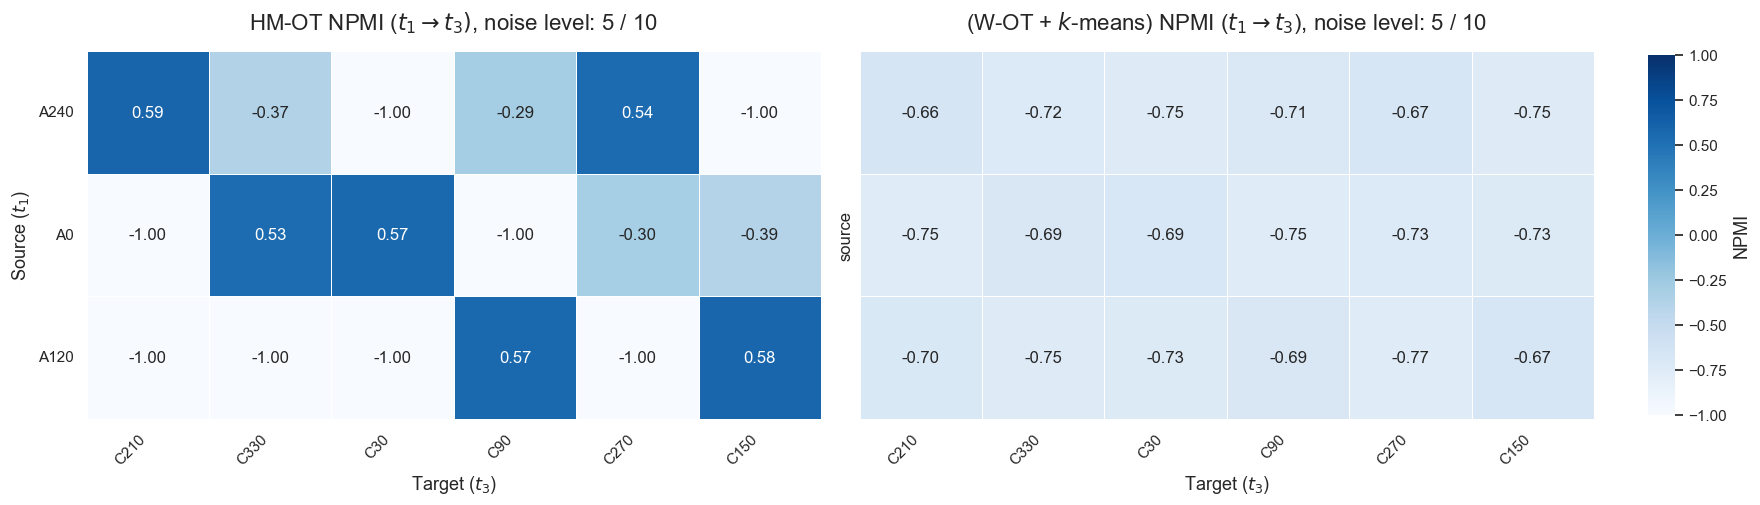

noise level 3.111111111111111


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_29462/3260667041.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


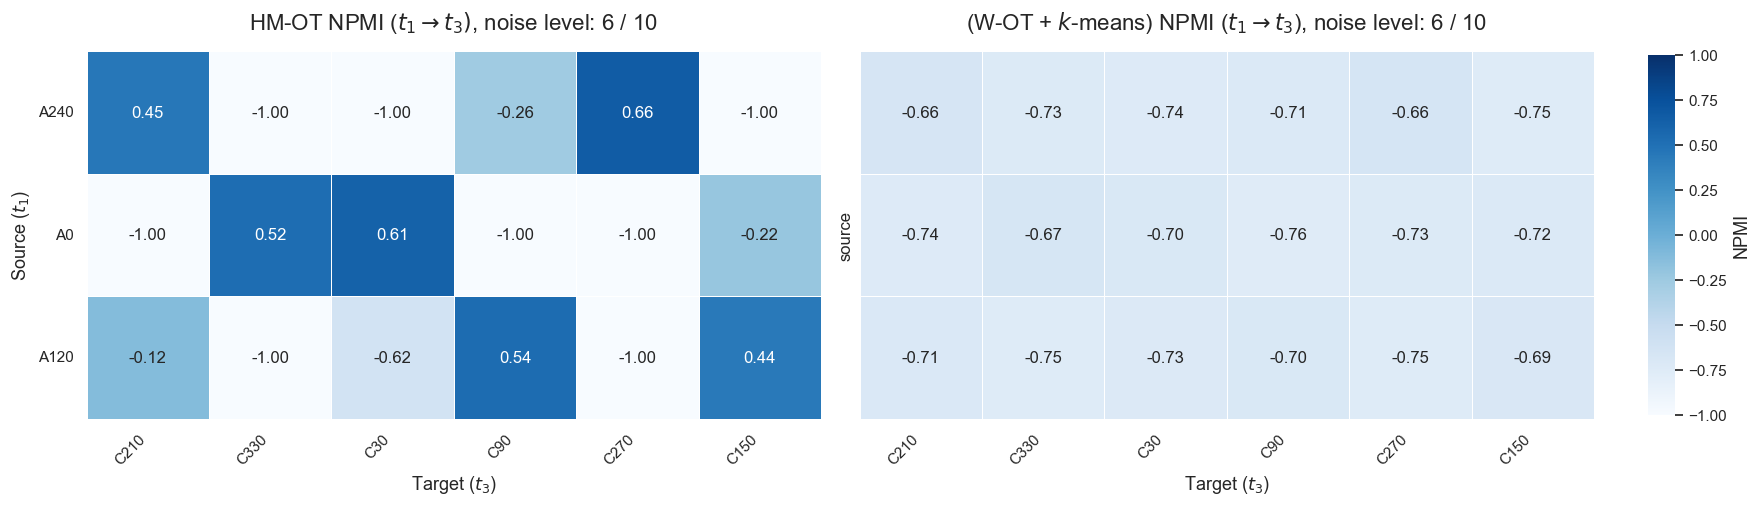

/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_29462/3260667041.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


noise level 3.333333333333333


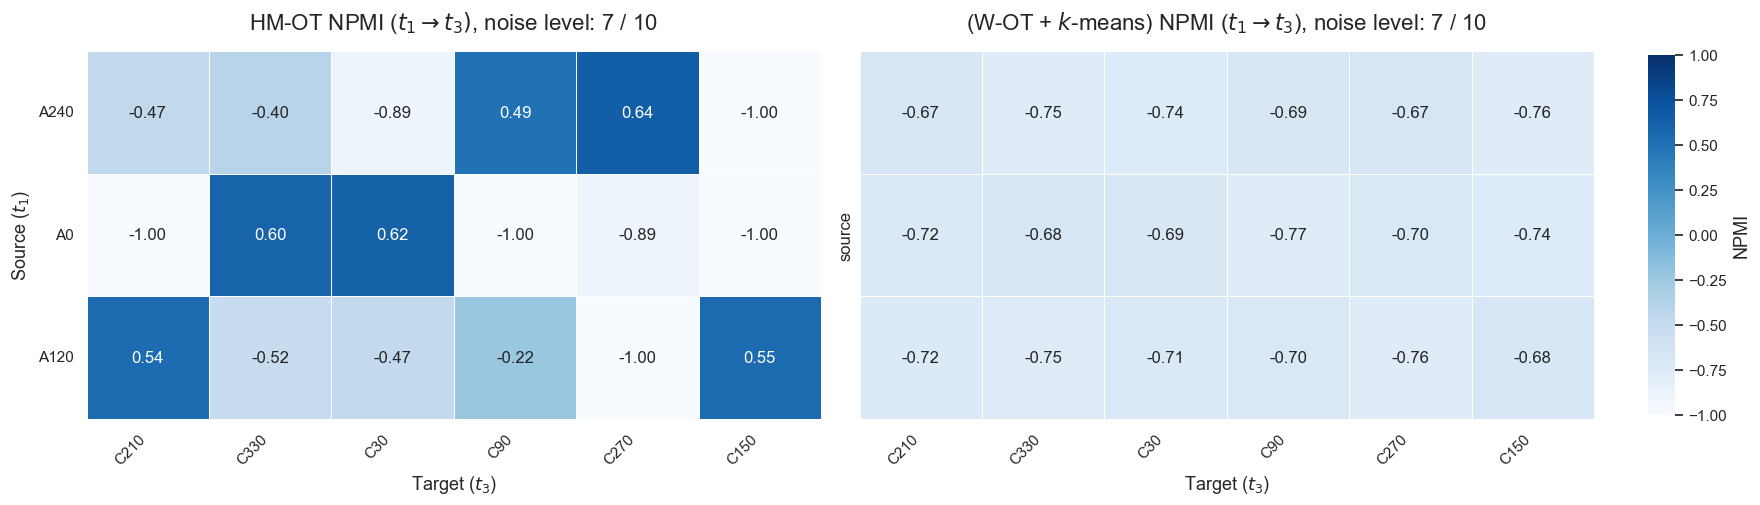

noise level 3.5555555555555554


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_29462/3260667041.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


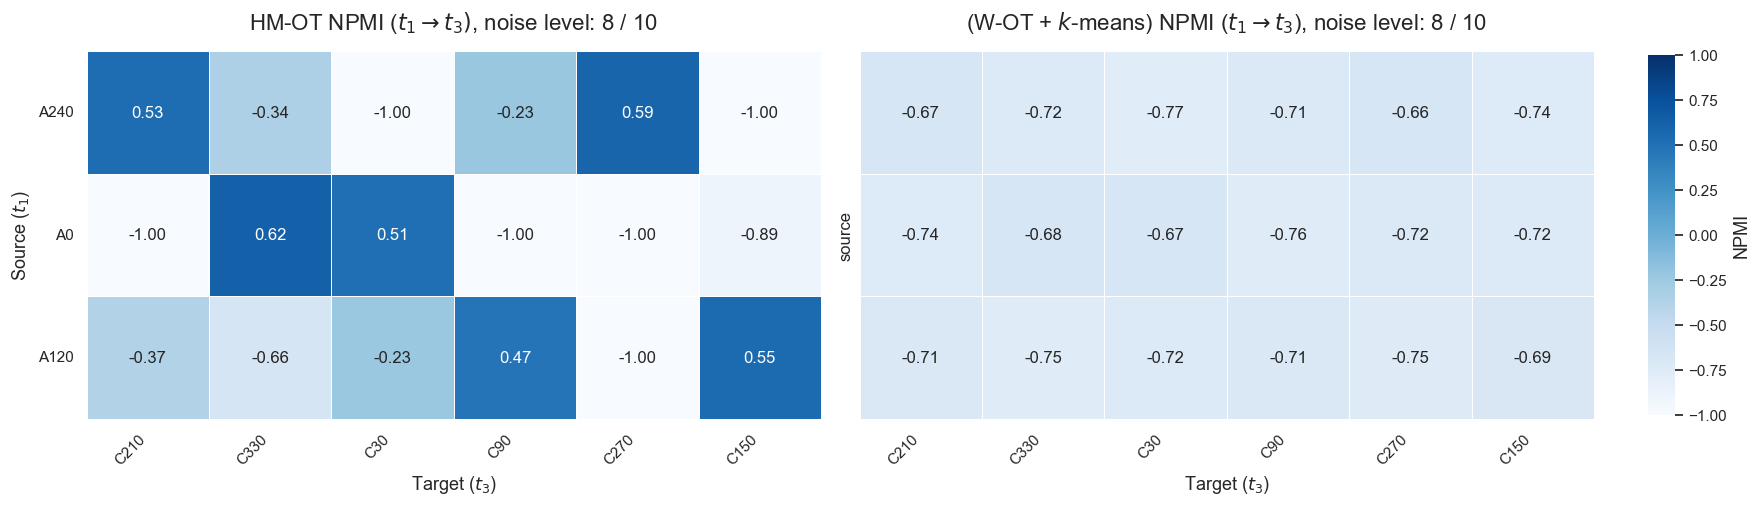

noise level 3.7777777777777777


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_29462/3260667041.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


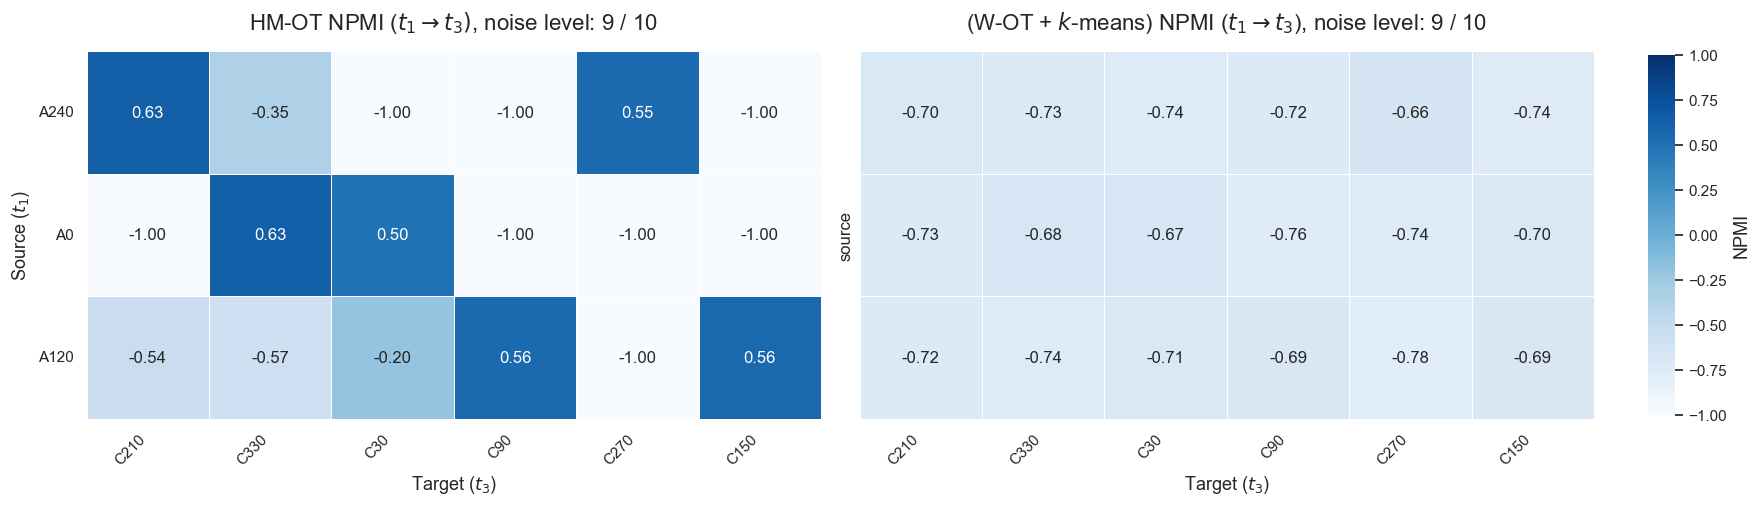

noise level 4.0


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_29462/3260667041.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


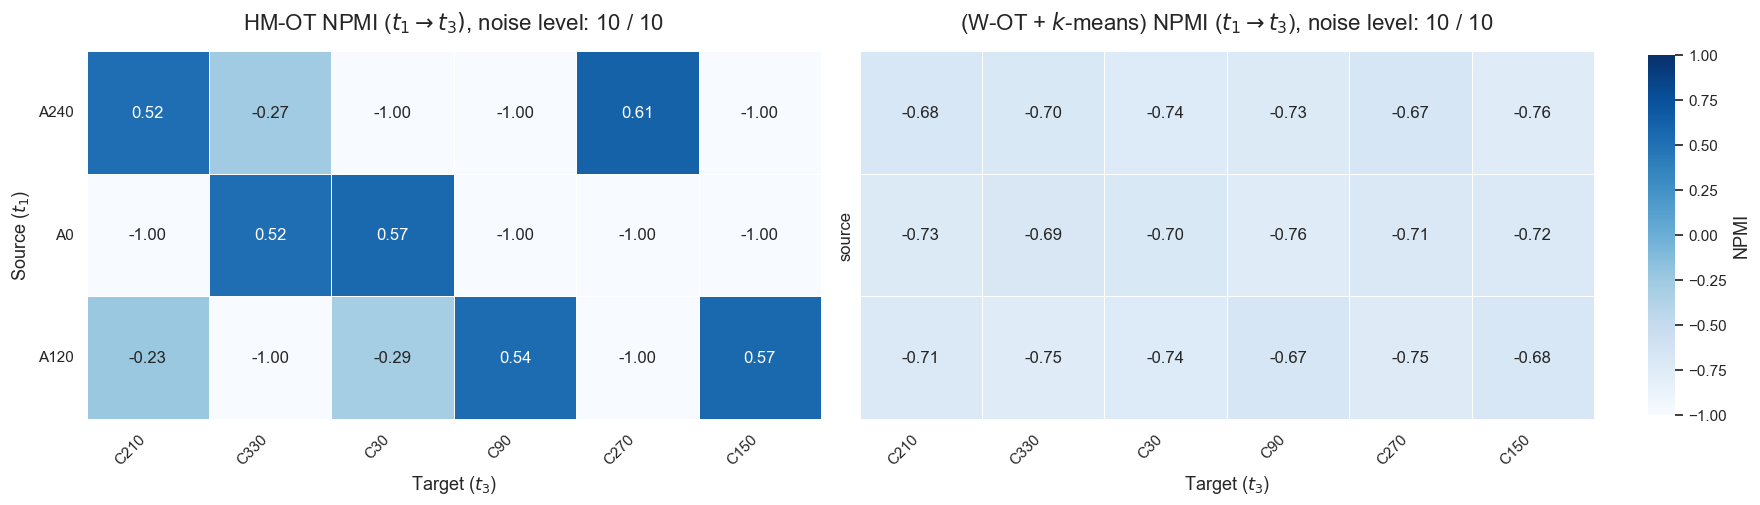

In [ ]:
# Canonical and filtered order
canonical_order = ['A240', 'A0', 'A120', 'B210', 'B90', 'B330', 'B30', 'B270', 'B150', 
                   'C210', 'C330', 'C30', 'C90', 'C270', 'C150']

cmap = 'Blues' # 'mako', 'seismic_r' 

for ind, level in enumerate(noise_level_range):
    print(f'noise level {level}')

    # Compute NPMI matrix for HM-OT
    hmot_NPMI_df = NPMI_t1_to_t3_matrix(hmot_Qs_list[ind], hmot_Ts_list[ind], NPMI_VALLEYS_LIST)
    hmot_npmi_matrix_ = hmot_NPMI_df.pivot(index="source", columns="target", values="npmi")

    # Sort and restrict to valleys in canonical order
    row_labels = [l for l in canonical_order if l in NPMI_VALLEYS_LIST[0]]
    col_labels = [l for l in canonical_order if l in NPMI_VALLEYS_LIST[2]]
    hmot_npmi_matrix = hmot_npmi_matrix_.reindex(index=row_labels, columns=col_labels)

    # Compute NPMI matrix for W-OT
    wot_NPMI_df = NPMI_t1_to_t3_matrix(km_Qs_list[ind], wot_Ts_list[ind], NPMI_VALLEYS_LIST)
    wot_npmi_matrix_ = wot_NPMI_df.pivot(index="source", columns="target", values="npmi")

    # Sort and restrict to valleys in canonical order
    wot_npmi_matrix = wot_npmi_matrix_.reindex(index=row_labels, columns=col_labels)

    hmot_npmi_matrix = hmot_npmi_matrix.fillna(-1)
    wot_npmi_matrix = wot_npmi_matrix.fillna(-1)

    # Determine global min/max across both matrices for shared color scale
    vmin = -1.0 # min(hmot_npmi_matrix.min().min(), wot_npmi_matrix.min().min())
    vmax = 1.0 # max(hmot_npmi_matrix.max().max(), wot_npmi_matrix.max().max())

    # Set seaborn theme
    sns.set_theme(style="white", context="notebook")

    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(18, 9), sharey=True)

    # Plot HM-OT heatmap
    sns.heatmap(
        hmot_npmi_matrix,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        linecolor='white',
        square=True,
        ax=axes[0],
        cbar=False  # defer colorbar
    )
    axes[0].set_title(f"HM-OT NPMI ($t_1 \\rightarrow t_3)$, noise level: {ind+1} / {len(noise_level_range)}", fontsize=16, pad=16)
    axes[0].set_xlabel("Target ($t_3$)", fontsize=13)
    axes[0].set_ylabel("Source ($t_1$)", fontsize=13)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right", fontsize=11)
    axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, fontsize=11)

    # Plot W-OT heatmap
    hm = sns.heatmap(
        wot_npmi_matrix,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        linecolor='white',
        square=True,
        ax=axes[1],
        cbar=True,
        cbar_ax=fig.add_axes([0.92, 0.3, 0.015, 0.4])  # manual position for shared colorbar
    )
    axes[1].set_title(f"(W-OT + $k$-means) NPMI ($t_1 \\rightarrow t_3$), noise level: {ind+1} / {len(noise_level_range)}", fontsize=16, pad=16)
    axes[1].set_xlabel("Target ($t_3$)", fontsize=13)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right", fontsize=11)
    # axes[1].set_yticklabels([])  # avoid redundant y-ticks

    # Label the shared colorbar
    hm.collections[0].colorbar.set_label("NPMI", fontsize=13)

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
    plt.show()